In [67]:
import os
import librosa 
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pandas as pd
import json
import time
import pydub 
import audio2numpy
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix, classification_report
from sklearn.tree import export_graphviz
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB
from skmultilearn.problem_transform import LabelPowerset
from skmultilearn.adapt import MLkNN
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from kneed import KneeLocator
from sklearn.cluster import KMeans
from scipy.cluster import hierarchy 
from scipy.spatial.distance import pdist
from sklearn import decomposition
from sklearn import metrics
from sklearn import datasets
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, SpectralClustering
from sklearn.ensemble import RandomForestClassifier



In [1]:
#from google.colab import drive # это подключает гугл-диск Даши, чтобы с него взять файлы
#drive.mount('/content/drive/')

Mounted at /content/drive/


# 1) Исследование про загрузку треков librosa

In [2]:
# Чтение

audio_path = './track/aux-88_alien-life-form.mp3'  # задаем путь до файла mp3
signal, sampling_rate = librosa.load(audio_path) # пробная загрузка одного трека целиком

# При исполнении всплывает Предупреждение о том, что стандартный способ чтения PySoundFile не срабатывает, librosa переходит к вспомогательному способу через другой модуль audioread
# Согласно документации (https://pypi.org/project/librosa/), соответственно, для того, чтобы получилось считать, нужно помимо librosa поставить audioread - pip install audioread / conda install -c conda-forge audioread
# Еще одной особенностью подгрузки является требование уже для audioread программы FFmpeg - pip3 install ffmpeg / conda install -c conda-forge ffmpeg

# Такой способ загрузки не является оптимальным, так как время считывания одного трека довольно велико (до секунды) - обсуждение проблемы https://stackoverflow.com/questions/59854527/librosa-load-takes-too-long-to-loadsample-mp3-files
# Существующие альтернативы - 
# (1) использование для считывания mp3 модуля pydub (https://stackoverflow.com/questions/53633177/how-to-read-a-mp3-audio-file-into-a-numpy-array-save-a-numpy-array-to-mp3)
# (2) перевод треков в формат wav через командную строку и FFmpeg, и последующая подгрузка стандартным способом через librosa 
# (3) использование для подгрузки модуля audio2numpy (https://pypi.org/project/audio2numpy/) - попробовал его, он выдает sampling_rate 44.1KHz по умолчанию, а в остальном все также + также требует установки FFmpeg

/home/kupaeva/miniconda3/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [3]:
print(signal.shape, sampling_rate) # размер эррея - больше трех млн флотов, что, наверно, не хорошо для памяти с учетом количества треков

(5027928,) 22050


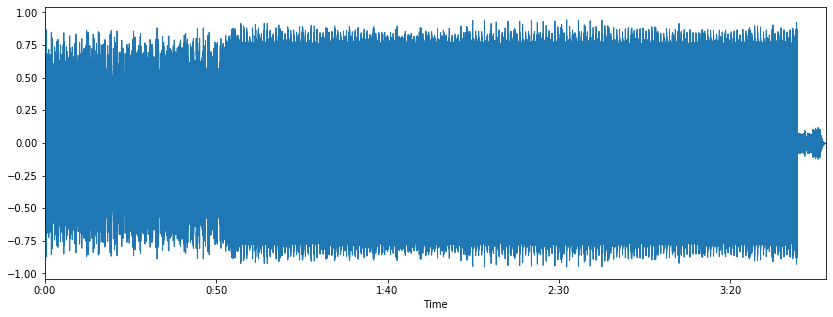

In [4]:
# Визуализация эррея во времени

plt.figure(figsize=(14, 5))
librosa.display.waveplot(signal, sr=sampling_rate) 

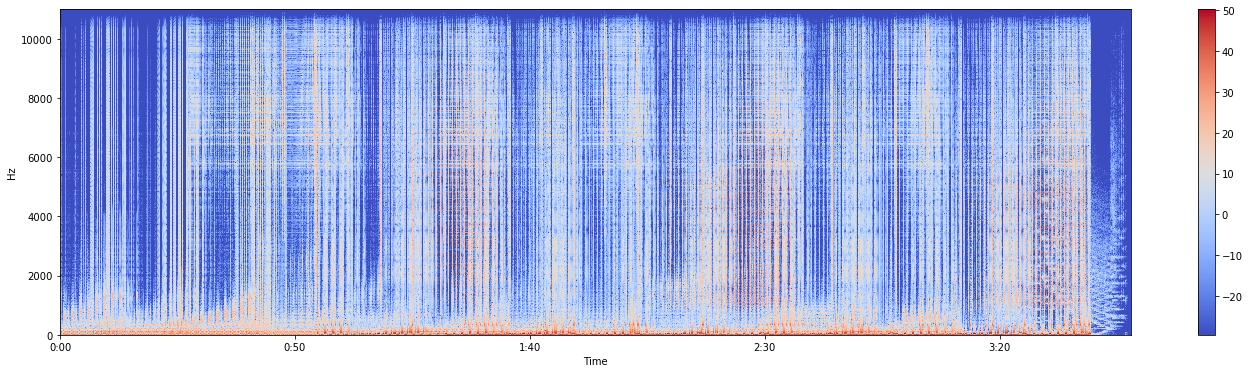

In [5]:
# Визуализация эррея в виде спектрограммы

X = librosa.stft(signal)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(24, 6))
librosa.display.specshow(Xdb, sr=sampling_rate, x_axis='time', y_axis='hz')
plt.colorbar()

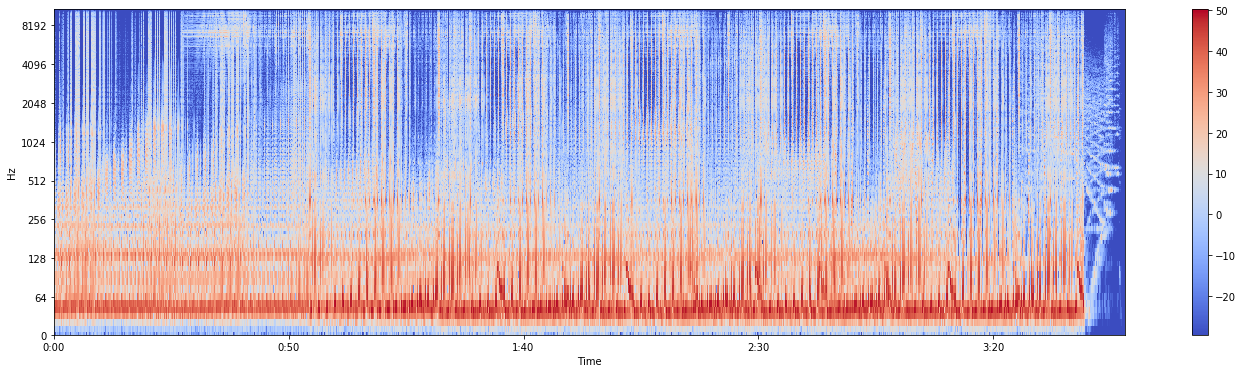

In [6]:
# Лог преобразование для вытаскивания наибольшего варьирования на низких частотах

plt.figure(figsize=(24, 6))
librosa.display.specshow(Xdb, sr=sampling_rate, x_axis='time', y_axis='log')
plt.colorbar()

## Тестирование скорости подгрузки треков:

In [7]:
# 1 - прямой способ через librosa -> audioread с sampling_rate по умолчанию, и нет
s = time.time()
signal_test, sampling_rate_test = librosa.load(audio_path)
print('time taken =', time.time() - s)

/home/kupaeva/miniconda3/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


time taken = 10.65503978729248


In [8]:
s = time.time()
signal_test, sampling_rate_test = librosa.load(audio_path, sr=44100) # пока не понимаю, почему так, но это так - может не унжно больше ничего выдумывать, итак сойдет :)
print('time taken =', time.time() - s)

/home/kupaeva/miniconda3/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


time taken = 1.063830852508545


In [9]:
# 2 - audio2numpy
s = time.time()
signal_test, sampling_rate_test = audio2numpy.open_audio(audio_path)
print('time taken =', time.time() - s)

time taken = 0.6220457553863525


In [10]:
# 3 - pydub
s = time.time()
signal_test = pydub.AudioSegment.from_mp3(audio_path)
print('time taken =', time.time() - s)

time taken = 0.7022075653076172


## Ресемплинг для уменьшения размера эрреев

In [11]:
signal_test, sampling_rate_test = librosa.load(audio_path, sr=44100)
print(signal_test.shape)

/home/kupaeva/miniconda3/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


(10055855,)


In [12]:
signal_test_resembled = librosa.resample(signal_test, sampling_rate_test, 8000)
print(signal_test_resembled.shape)

(1824192,)


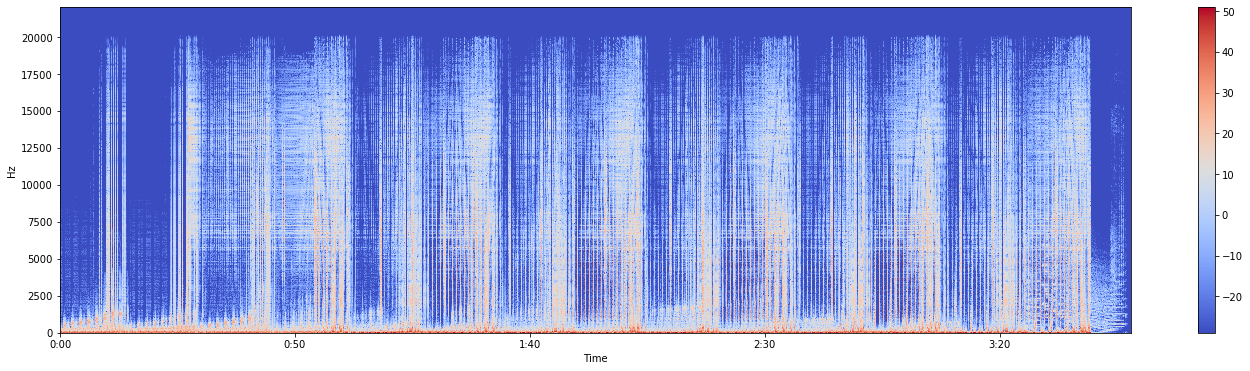

In [13]:
X = librosa.stft(signal_test)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(24, 6))
librosa.display.specshow(Xdb, sr=sampling_rate_test, x_axis='time', y_axis='hz')
plt.colorbar()

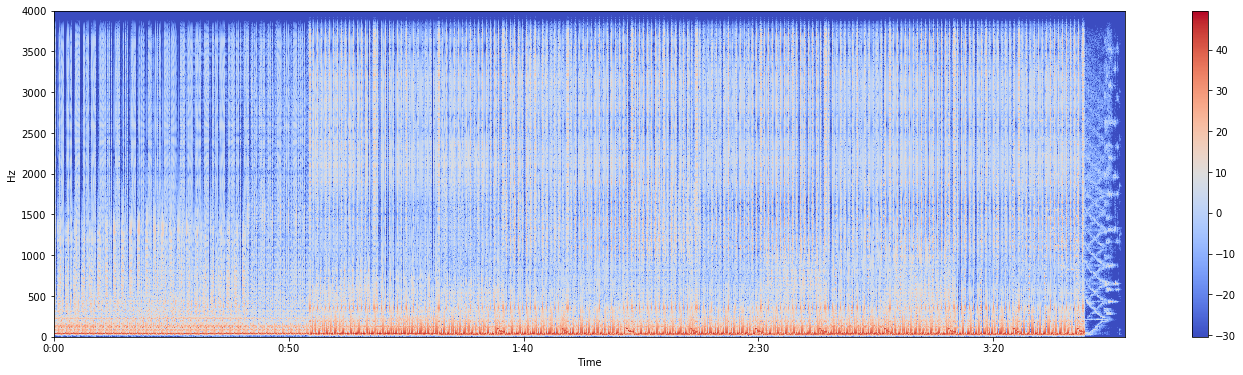

In [14]:
X = librosa.stft(signal_test_resembled)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(24, 6))
librosa.display.specshow(Xdb, sr=8000, x_axis='time', y_axis='hz')
plt.colorbar()

Судя по спектрограммам, ресемплинг трека сильно влияет на качество и извлечение фич, поэтому не будем так делать, если памяти будет хватать.

# 2) Процессинг файлов, извлечение фич

In [ ]:
Исходно мы решили сделать 2 выборки: 
1) обучающую, основанную на треках из датасета GTZAN (10 жанров по 10 треков) + 100 треков электроники из плейлистов Планетроника
2) тестовую, состояющую из треков студентов ИБ, у которых основной жанр сведен к жанрам, представленным в обучающей выборке.
Поэтому мы запустили этот раздел 2 раза для разных треков, и выгрузили результаты. В дальнейшем мы подгружали фичи из файла и работали с ними. 

In [15]:
# путь до папки с треками
path_to = '/media/kupaeva/21B5-5943/YandexDisk/IB/ML/music/data/genres_original/'

In [16]:
column_names = ['file_title', 'duration', 'chroma_stft_mean', 'chroma_stft_var',
                     'spectral_centroid_mean', 'spectral_centroid_var', 'spectral_bandwidth_mean', 'spectral_bandwidth_var', 
                     'rolloff_mean', 'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var', 'harmony_mean', 'harmony_var', 'tempo']
df = pd.DataFrame(columns = column_names) # создание пустого датафрейма, в который будут добавляться фичи

In [17]:
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
for file in files:
    title = file
    path_to_file = path + file
    
    # rough feature extraction
    y, sr = librosa.load(path_to_file, sr=44100)
    duration = librosa.get_duration(y=y, sr=sr)
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y=y)
    harmony = librosa.effects.harmonic(y=y)
    tempo = librosa.beat.tempo(y=y, sr=sr)
    
    # наращивание датафрейма
    df_temp = pd.DataFrame([[file, 
                             duration,
                             chroma_stft.mean(),
                             chroma_stft.var(),
                             spec_cent.mean(),
                             spec_cent.var(),
                             spec_bw.mean(),
                             spec_bw.var(),
                             rolloff.mean(),
                             rolloff.var(),
                             zcr.mean(),
                             zcr.var(),
                             harmony.mean(),
                             harmony.var(),
                             tempo
                            ]], 
                           columns=column_names)
    df = df.append(df_temp)

NameError: name 'files' is not defined

In [ ]:
df.to_csv('/content/drive/MyDrive/music/df_features.csv') # выгружаем фичи для обучающей выборки

In [ ]:
# подготовка метаданных для обучающего датафрейма
column_names_genres = ['file_title', 'genres']
df = pd.DataFrame(columns = column_names)

genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

for genre in genres: # это для kaggle
    path_to_genre = path_to + genre
    track_list = os.listdir(path_to_genre)
    track_df = pd.DataFrame(columns = column_names)
    track_df['genres'] = [genre]*100
    track_df['file_title'] = track_list
    df = df.append(track_df)

# а это для скачанной вручную электроники. Соответственно, все треки электроники взяты из плейлистов планетроники.     
path_to_electro = '/media/kupaeva/21B5-5943/YandexDisk/IB/ML/music/electro'
electro_list = os.listdir(path_to_electro)
track_df = pd.DataFrame(columns = column_names)
track_df['genres'] = ['electronica']*100
track_df['file_title'] = electro_list

df = df.append(track_df)
df.to_csv('/media/kupaeva/21B5-5943/YandexDisk/IB/ML/music/data/train_kaggle.csv')

df.to_csv('/content/drive/MyDrive/music/train_kaggle_full.csv') # выгружаем метаданные для обучающей выборки


# 3) Подготавливаем фичи для дальнейшего анализа


In [18]:
# подгружаем из диска файлы с фичами и метаданными
features_train = pd.read_csv('./df_features.csv')
features_test = pd.read_csv('./test_features.csv')
meta_test = pd.read_csv('./fixed_data_final.csv')
meta_train = pd.read_csv('./train_kaggle_full.csv')

In [19]:
features_test.head(3)

file_title    duration  chroma_stft_mean  \
0                       Tortuga_-_My_Block.mp3  273.473696          0.511729   
1  Оргазм_Нострадамуса—Раздражение_аморала.mp3  182.648163          0.485090   
2                    Свидание-Я_и_твой_кот.mp3  244.117664          0.507524   

   chroma_stft_var  spec_cent_mean  spec_cent_var  spec_bw_mean   spec_bw_var  \
0         0.083302     3442.051650   2.883000e+06   3700.874664  1.171441e+06   
1         0.083017     3931.589618   1.016064e+06   3571.153567  2.835666e+05   
2         0.076009     1960.239764   1.828401e+06   2853.390533  1.250619e+06   

   rolloff_mean   rolloff_var  zcr_mean   zcr_var  harmony_mean  harmony_var  \
0   7035.072791  1.106361e+07  0.073445  0.005399      0.000190     0.118548   
1   7828.154906  3.446974e+06  0.112774  0.002711     -0.000108     0.049794   
2   3999.211575  1.047026e+07  0.034273  0.001669     -0.000015     0.038252   

            tempo  
0  [126.04801829]  
1  [135.99917763]  
2  [101.33272059]

In [20]:
# ставим нормальные заголовки датафреймов
features_train.columns = ['','file_title', 'duration', 'chroma_stft_mean', 'chroma_stft_var',
                     'spectral_centroid_mean', 'spectral_centroid_var', 'spectral_bandwidth_mean', 'spectral_bandwidth_var', 
                     'rolloff_mean', 'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var', 'harmony_mean', 'harmony_var', 'tempo']
features_test.columns = ['file_title', 'duration', 'chroma_stft_mean', 'chroma_stft_var',
                     'spectral_centroid_mean', 'spectral_centroid_var', 'spectral_bandwidth_mean', 'spectral_bandwidth_var', 
                     'rolloff_mean', 'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var', 'harmony_mean', 'harmony_var', 'tempo']
meta_train.columns = ['file_title', 'coarse_genre']
meta_test.columns = ['old_name', 'student', 'coarse_genre', 'genre1', 'genre2', 'genre3', 'file_title']




In [21]:
# приводим к нормальному виду tempo
features_train['tempo'] = features_train['tempo'].apply(lambda x: float(json.loads(x)[0]))
features_test['tempo'] = features_test['tempo'].apply(lambda x: float(json.loads(x)[0]))

In [22]:
# мержим метаданные и фичи
test_merged = features_test.merge(meta_test, left_on='file_title', right_on='file_title')
train_merged = features_train.merge(meta_train, left_on='file_title', right_on='file_title')

In [23]:
# проверка, сработало ли
test_merged.shape

(185, 21)

In [24]:
# приводим все написания жанров к маленьким буквам
test_merged['coarse_genre'] = test_merged['coarse_genre'].str.lower()

In [37]:
test_merged.groupby('coarse_genre').describe() #статистика по жанрам

duration                                                  \
                count        mean         std         min         25%   
coarse_genre                                                            
classical        17.0  513.266001  976.087938  135.601633  208.754558   
country           6.0  254.862585   90.600768  187.062857  196.289541   
electronica      72.0  296.253844   94.604823  106.675918  232.562976   
hiphop           11.0  196.197879   41.036214  128.915351  173.229059   
jazz              3.0  238.074664  108.510235  148.514830  177.741497   
metal            19.0  338.580364  130.774753  237.040000  270.346803   
pop              13.0  206.357429   44.870193  135.020658  178.272993   
rock             44.0  246.894086   83.127625  149.551020  207.284575   

                                                  chroma_stft_mean            \
                     50%         75%          max            count      mean   
coarse_genre                                                                   
classical     276.373333  285.066667  4270.464014             17.0  0.382921   
country       214.979864  280.208980   420.141474              6.0  0.463428   
electronica   273.905828  341.052857   595.226122             72.0  0.532723   
hiphop        213.343107  217.042721   243.946667             11.0  0.494531   
jazz          206.968163  282.854580   358.740998              3.0  0.425400   
metal         321.438707  358.283299   834.690612             19.0  0.498495   
pop           204.280000  243.187075   272.179977             13.0  0.430793   
rock          228.019252  277.503333   685.480000             44.0  0.467943   

              ... harmony_var           tempo                         \
              ...         75%       max count        mean        std   
coarse_genre  ...                                                      
classical     ...    0.024836  0.077262  17.0  124.878726  10.358192   
country       ...    0.034892  0.044699   6.0  110.901197   4.530220   
electronica   ...    0.068750  0.222000  72.0  123.167086  16.370427   
hiphop        ...    0.053818  0.067181  11.0  129.116165  23.099457   
jazz          ...    0.024291  0.027569   3.0  128.152150  25.423643   
metal         ...    0.041286  0.049600  19.0  131.000330  16.291938   
pop           ...    0.039873  0.050585  13.0  118.844738  16.949166   
rock          ...    0.053764  0.092210  44.0  124.259920  19.998256   

                                                                          
                     min         25%         50%         75%         max  
coarse_genre                                                              
classical     105.468750  120.185320  123.046875  126.048018  143.554688  
country       103.359375  108.836298  112.347147  114.219599  114.843750  
electronica    86.132812  116.801314  123.046875  132.512019  161.499023  
hiphop         99.384014  118.819578  120.185320  134.255598  178.205819  
jazz          107.666016  113.925668  120.185320  138.395217  156.605114  
metal         109.956782  118.819578  126.048018  143.554688  161.499023  
pop            95.703125  109.956782  120.185320  120.185320  161.499023  
rock           93.963068  107.666016  123.046875  135.999178  166.708669  

[8 rows x 112 columns]

In [39]:
train_merged.groupby('coarse_genre').describe() #статистика по жанрам

...       tempo                        
              count mean  std  ...         50%         75%         max
coarse_genre                   ...                                    
blues         100.0  0.0  0.0  ...  123.046875  135.999178  166.708669
classical     100.0  0.0  0.0  ...  123.046875  132.512019  184.570312
country       100.0  0.0  0.0  ...  126.048018  139.674831  172.265625
disco         100.0  0.0  0.0  ...  123.046875  129.199219  161.499023
electronica   100.0  0.0  0.0  ...  123.046875  129.199219  178.205819
hiphop        100.0  0.0  0.0  ...  105.468750  123.797161  184.570312
jazz          100.0  0.0  0.0  ...  120.185320  129.199219  161.499023
metal         100.0  0.0  0.0  ...  123.046875  135.999178  166.708669
pop           100.0  0.0  0.0  ...  109.956782  126.048018  166.708669
reggae        100.0  0.0  0.0  ...  132.512019  151.999081  184.570312
rock          100.0  0.0  0.0  ...  120.185320  132.512019  166.708669

[11 rows x 120 columns]

In [25]:
test_merged_to_plot = test_merged.drop(['student', 'genre1', 'genre2', 'genre3', 'file_title'], axis=1)

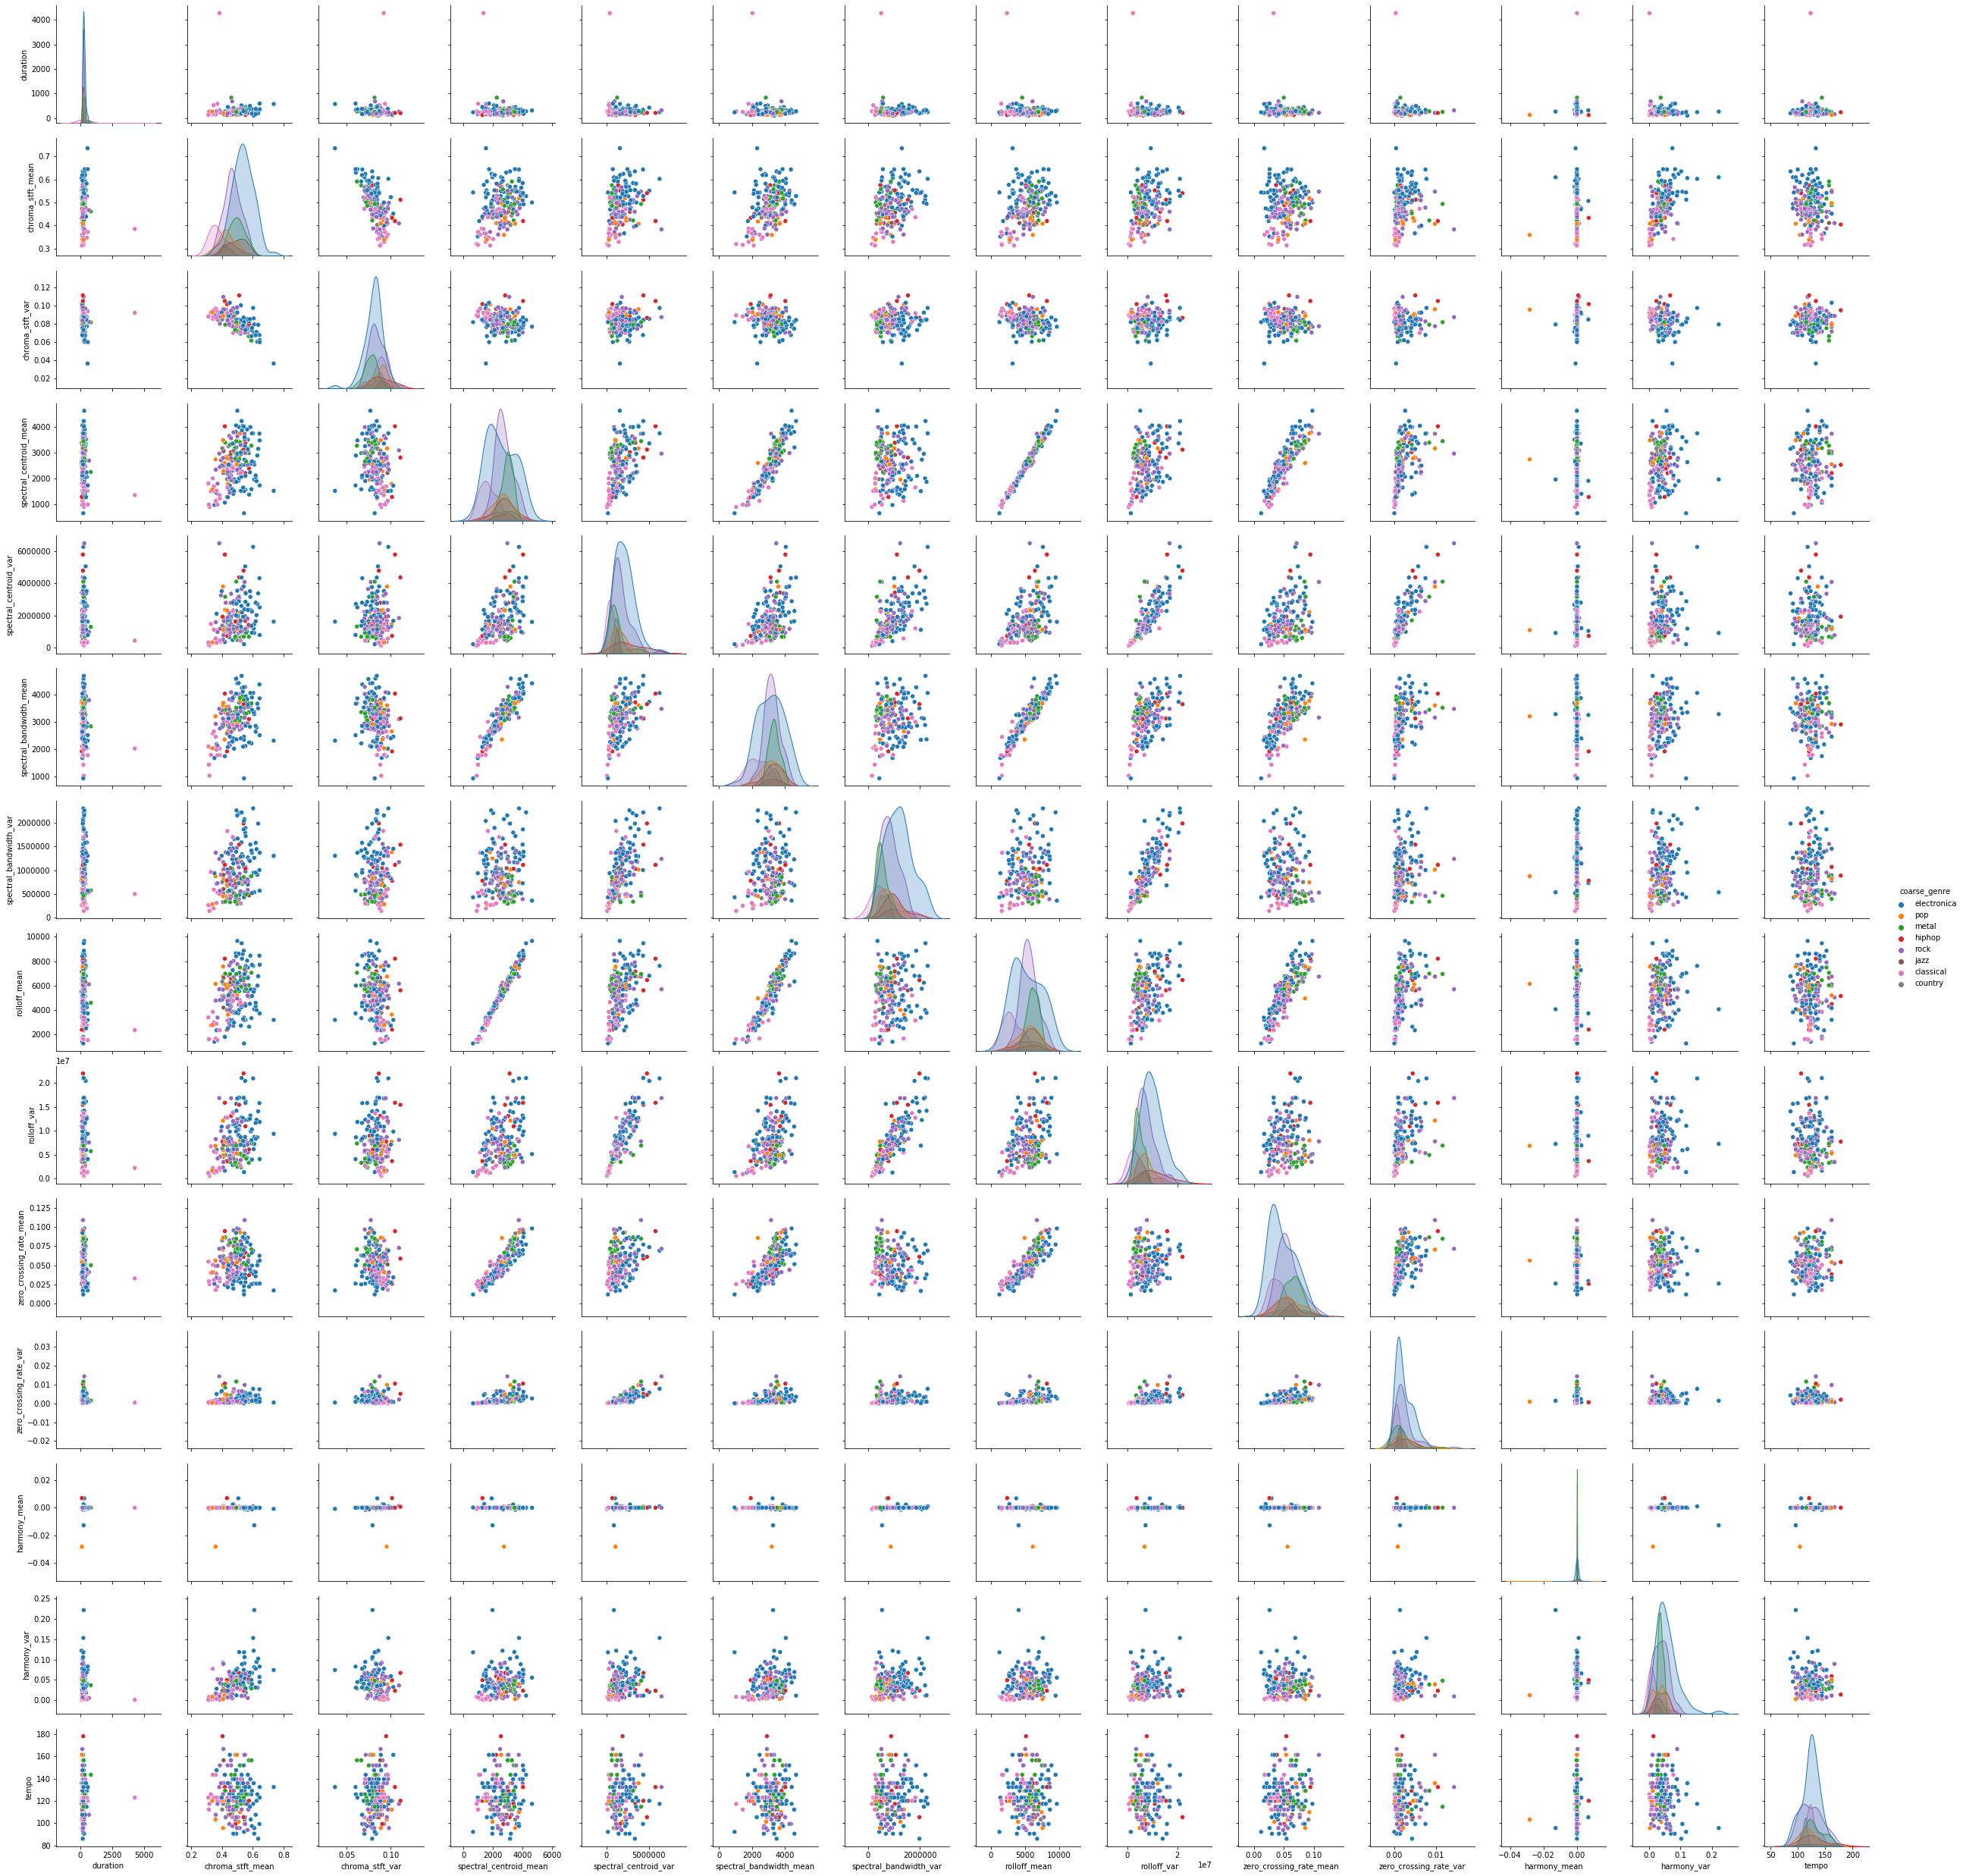

In [26]:
# ну можно посмотреть, что как в тесте 
sns.pairplot(test_merged_to_plot, hue='coarse_genre')

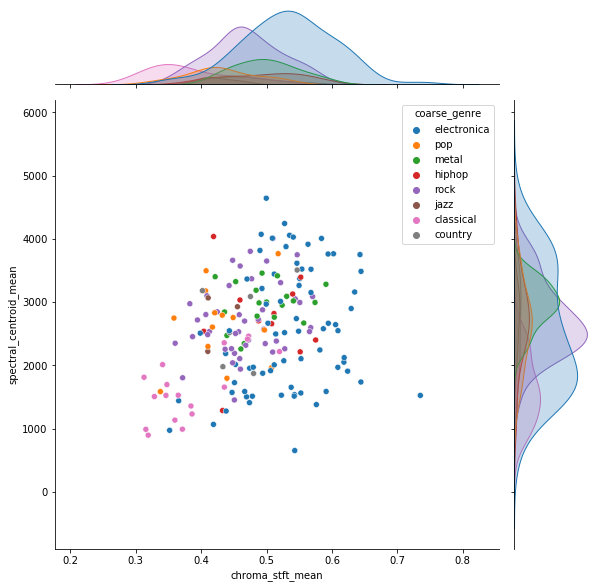

In [27]:
sns.jointplot(x = 'chroma_stft_mean', y = 'spectral_centroid_mean', hue = 'coarse_genre', data = test_merged_to_plot, height=8.27)

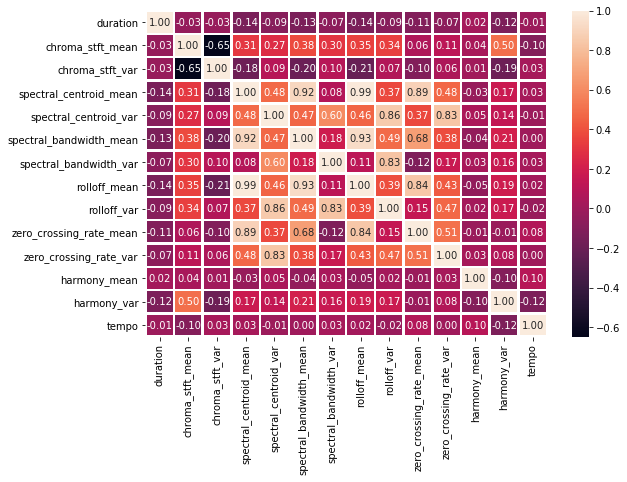

In [28]:
corr = test_merged_to_plot.corr()
f,ax = plt.subplots(figsize=(9,6))
sns.heatmap(corr, annot = True, linewidths=1.5 , fmt = '.2f',ax=ax)
plt.show()

# 4) Кластеризация

In [29]:
X = test_merged.drop(columns=['file_title','old_name', 'student', 'genre1', 'genre2', 'genre3'], axis = 1)
#X = X.drop(['Unnamed: 0'], axis= 1)
X = X.drop([160,])
X.head()

duration  chroma_stft_mean  chroma_stft_var  spectral_centroid_mean  \
0  273.473696          0.511729         0.083302             3442.051650   
1  244.117664          0.507524         0.076009             1960.239764   
2  394.155283          0.530715         0.079255             3089.888430   
3  332.199184          0.567891         0.071394             3518.049120   
4  150.492494          0.459269         0.087992             3032.166267   

   spectral_centroid_var  spectral_bandwidth_mean  spectral_bandwidth_var  \
0           2.883000e+06              3700.874664            1.171441e+06   
1           1.828401e+06              2853.390533            1.250619e+06   
2           6.751195e+05              3929.790301            7.171547e+05   
3           2.674195e+06              3679.202446            1.271660e+06   
4           2.786480e+06              3790.248778            9.085854e+05   

   rolloff_mean   rolloff_var  zero_crossing_rate_mean  \
0   7035.072791  1.106361e+07                 0.073445   
1   3999.211575  1.047026e+07                 0.034273   
2   6765.677241  4.845344e+06                 0.051433   
3   7476.593922  1.234161e+07                 0.086108   
4   6547.930958  1.312970e+07                 0.058501   

   zero_crossing_rate_var  harmony_mean  harmony_var       tempo coarse_genre  
0                0.005399      0.000190     0.118548  126.048018  electronica  
1                0.001669     -0.000015     0.038252  101.332721          pop  
2                0.000496     -0.000005     0.044011  126.048018        metal  
3                0.003908     -0.001493     0.051288  143.554688  electronica  
4                0.004182      0.000012     0.041802  129.199219       hiphop

In [30]:

X1 = train_merged
#X1 = kaggle.drop(['Unnamed: 0', 'Unnamed: 1'], axis= 1)
y1 = X1['coarse_genre']
X1 = X1.drop(['file_title',], axis = 1) #'coarse_genre'
X1.head()



duration  chroma_stft_mean  chroma_stft_var  spectral_centroid_mean  \
0  0  30.013333          0.409662         0.089260             1726.100214   
1  0  30.013333          0.439002         0.092933             1450.621228   
2  0  30.013333          0.420743         0.084665             1493.274754   
3  0  30.013333          0.547730         0.071163              996.797580   
4  0  30.013333          0.336912         0.087932             1749.550176   

   spectral_centroid_var  spectral_bandwidth_mean  spectral_bandwidth_var  \
0          141688.671771              1965.787103            91152.467367   
1          379060.231221              1971.739422           230486.010960   
2          175472.398363              1698.247838            94511.265535   
3          184735.219571              1524.390568           179363.511602   
4          357721.288579              1700.629027           106872.421421   

   rolloff_mean   rolloff_var  zero_crossing_rate_mean  \
0   3669.196194  9.418320e+05                 0.043103   
1   3292.531676  2.996034e+06                 0.029515   
2   2891.078161  9.202708e+05                 0.038998   
3   1994.802297  1.433874e+06                 0.017085   
4   3388.540118  1.719364e+06                 0.051998   

   zero_crossing_rate_var  harmony_mean  harmony_var       tempo coarse_genre  
0                0.000279  1.251719e-06     0.009209  126.048018        blues  
1                0.000488  4.150676e-05     0.005607  105.468750        blues  
2                0.000320 -2.473043e-06     0.017534  156.605114        blues  
3                0.000141 -4.409932e-07     0.020581   99.384014        blues  
4                0.000621 -4.252011e-06     0.005669  135.999178        blues

In [31]:
all_data = pd.merge(X,X1, how = 'outer')
all_data = all_data.dropna()
all_x = all_data.drop(['coarse_genre'], axis = 1)
all_y = all_data['coarse_genre']
all_y = all_y.str.lower() #перевод Electronica в electronica и Pop в pop
all_y.unique()

array(['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz',
       'metal', 'pop', 'reggae', 'rock', 'electronica'], dtype=object)

In [32]:
all_y = all_y.replace(to_replace = 'classical', value = 'classic')
# summarize the dataset
print(all_x.shape, all_y.shape)
print(Counter(all_y))


(1100, 15) (1100,)
Counter({'blues': 100, 'classic': 100, 'country': 100, 'disco': 100, 'hiphop': 100, 'jazz': 100, 'metal': 100, 'pop': 100, 'reggae': 100, 'rock': 100, 'electronica': 100})


In [33]:
scaler = StandardScaler() #with_std = False, with_mean = False
all_scaled = scaler.fit_transform(all_x)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(all_scaled, all_y, test_size = 0.33, random_state = 5)

## Мультиноминальная регрессия

In [35]:
model1 = LogisticRegression(random_state=42, multi_class='multinomial', penalty='l2', solver= 'newton-cg', class_weight='balanced', C=0.05).fit(X_train, y_train)
preds = model1.predict(X_test)

In [36]:
logit_model=sm.MNLogit(y_train,sm.add_constant(X_train))
logit_model
result=logit_model.fit()
stats1=result.summary()
stats2=result.summary2()
print(stats1)
print(stats2)

Optimization terminated successfully.
         Current function value: nan
         Iterations 6
                          MNLogit Regression Results                          
Dep. Variable:           coarse_genre   No. Observations:                  737
Model:                        MNLogit   Df Residuals:                      587
Method:                           MLE   Df Model:                          140
Date:                Sat, 24 Apr 2021   Pseudo R-squ.:                     nan
Time:                        17:44:33   Log-Likelihood:                    nan
converged:                       True   LL-Null:                       -1764.8
Covariance Type:            nonrobust   LLR p-value:                       nan
    coarse_genre=classic       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                           nan        nan        nan        nan         nan     

In [37]:
confusion_matrix(y_test, preds)
confmtrx = np.array(confusion_matrix(y_test, preds))
pd.DataFrame(confmtrx, index=['electronica', 'rock', 'metal', 'pop', 'hiphop', 'classic', 'country', 'jazz', 'blues', 'disco', 'reggae'], columns=['predicted_electronica', 'predicted_rock', 'predicted_metal', 'predicted_pop', 'predicted_hiphop', 'predicted_classic', 'predicted_country', 'predicted_jazz', 'predicted_blues', 'predicted_disco', 'predicted_reggae'])


predicted_electronica  predicted_rock  predicted_metal  \
electronica                      5               2                1   
rock                             0              24                1   
metal                            4               4                9   
pop                              0               0                1   
hiphop                           1               0                0   
classic                          0               0                0   
country                          0               6                2   
jazz                             0               0                0   
blues                            0               0                0   
disco                            0               1                0   
reggae                           1               0                2   

             predicted_pop  predicted_hiphop  predicted_classic  \
electronica              3                 0                  1   
rock                     0                 0                  0   
metal                    0                 0                  0   
pop                     10                 0                  6   
hiphop                   0                36                  0   
classic                  2                 0                 27   
country                  2                 0                  1   
jazz                     3                 0                  1   
blues                    1                 0                  2   
disco                    0                 0                  7   
reggae                   9                 0                  4   

             predicted_country  predicted_jazz  predicted_blues  \
electronica                  8               1                0   
rock                         0               0                0   
metal                        5               1                2   
pop                          3               5                2   
hiphop                       0               1                0   
classic                      0               1               10   
country                     17               0                6   
jazz                         0              25                0   
blues                        3               0               27   
disco                        1               0                2   
reggae                       2              10                1   

             predicted_disco  predicted_reggae  
electronica                4                 1  
rock                       1                 0  
metal                      2                 3  
pop                        5                 3  
hiphop                     0                 0  
classic                    4                 1  
country                    0                 0  
jazz                       0                 0  
blues                      0                 1  
disco                     18                 1  
reggae                     4                 3

In [38]:
print('Accuracy Score:', metrics.accuracy_score(y_test, preds))  

#Create classification report
class_report=classification_report(y_test, preds)
print(class_report)

Accuracy Score: 0.5537190082644629
              precision    recall  f1-score   support

       blues       0.45      0.19      0.27        26
     classic       0.65      0.92      0.76        26
     country       0.56      0.30      0.39        30
       disco       0.33      0.29      0.31        35
 electronica       1.00      0.95      0.97        38
      hiphop       0.55      0.60      0.57        45
        jazz       0.44      0.50      0.47        34
       metal       0.57      0.86      0.68        29
         pop       0.54      0.79      0.64        34
      reggae       0.47      0.60      0.53        30
        rock       0.23      0.08      0.12        36

    accuracy                           0.55       363
   macro avg       0.53      0.55      0.52       363
weighted avg       0.53      0.55      0.52       363



## Kmeans

In [39]:
pca = PCA(n_components = 8)
pca_analysis = pca.fit_transform(X_train)
evr = pca.explained_variance_ratio_

scores_pca = pd.DataFrame(data = pca_analysis,
              columns = ['PC_1', 'PC_2', 'PC_3', 'PC_4]', 'PC_5', 'PC_6', 'PC_7', 'PC_8'])
print(evr)

[0.44919256 0.17926834 0.10804707 0.07584193 0.06119536 0.04826878
 0.02772778 0.02379148]


Optimal number of clusters 5


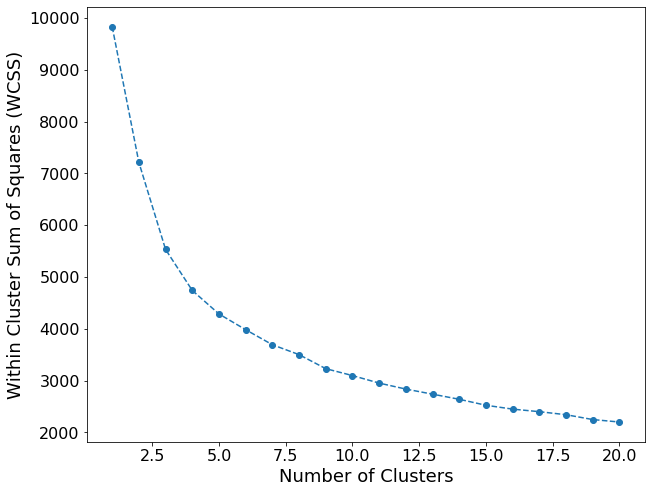

In [40]:
# get within cluster sum of squares for each value of k
wcss = []
max_clusters = 21
for i in range(1, max_clusters):
    kmeans_pca = KMeans(i, init='k-means++', random_state=42)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)
      
# programmatically locate the elbow
n_clusters = KneeLocator([i for i in range(1, max_clusters)], wcss, curve='convex', direction='decreasing').knee
print("Optimal number of clusters", n_clusters)
    
# visualize the curve in order to locate the elbow
fig = plt.figure(figsize=(10,8))
plt.plot(range(1, 21), wcss, marker='o', linestyle='--')
# plt.vlines(n_clusters, ymin=0, ymax=max(wcss), linestyles='dashed')
plt.xlabel('Number of Clusters', fontsize=18)
plt.ylabel('Within Cluster Sum of Squares (WCSS)', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

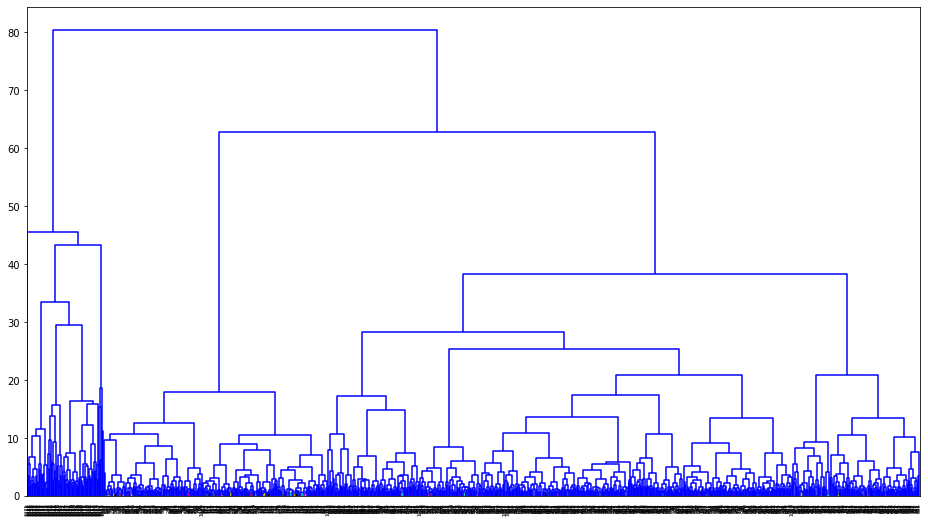

In [96]:
distance_mat = pdist(all_scaled)
Z = hierarchy.linkage(distance_mat, 'ward', optimal_ordering = True) # linkage — реализация агломеративного алгоритма, можно менять параметры на то, что вы хотите
plt.figure(figsize=(16, 9))
dn = hierarchy.dendrogram(Z, color_threshold=0.5)

In [41]:
algorithms = []
algorithms.append(KMeans(n_clusters= n_clusters, random_state=42))
algorithms.append(AffinityPropagation())
algorithms.append(SpectralClustering(n_clusters= n_clusters, random_state=42,
                                     affinity='nearest_neighbors'))
algorithms.append(AgglomerativeClustering(n_clusters= n_clusters))


data = []
for algo in algorithms:
    algo.fit(all_scaled)
    data.append(({
        'ARI': metrics.adjusted_rand_score(all_y, algo.labels_),
        'AMI': metrics.adjusted_mutual_info_score(all_y, algo.labels_),
        'Homogenity': metrics.homogeneity_score(all_y, algo.labels_),
        'Completeness': metrics.completeness_score(all_y, algo.labels_),
        'V-measure': metrics.v_measure_score(all_y, algo.labels_),
        'Silhouette': metrics.silhouette_score(all_scaled, algo.labels_)}))

results = pd.DataFrame(data=data, columns=['ARI', 'AMI','Homogenity'
                                           'Completeness', 'V-measure', 
                                           'Silhouette'],
                       index=['K-means', 'Affinity', 
                              'Spectral', 'Agglomerative'])

results

ARI       AMI  HomogenityCompleteness  V-measure  \
K-means        0.118006  0.257975                     NaN   0.264847   
Affinity       0.094169  0.285975                     NaN   0.368944   
Spectral       0.169324  0.376094                     NaN   0.382143   
Agglomerative  0.095359  0.294178                     NaN   0.301174   

               Silhouette  
K-means          0.217495  
Affinity         0.146458  
Spectral         0.122764  
Agglomerative    0.226053

# 5) Классификация по основному жанру

## RandomForest на разных наборах данных

In [42]:
# делаем X_train и y_train из обучающей выборки 
X_train = train_merged.drop(['', 'file_title', 'duration', 'coarse_genre'], axis=1)
y_train = train_merged['coarse_genre']
X_test = test_merged.drop(['file_title','duration','coarse_genre','genre1','genre2', 'genre3', 'old_name', 'student'], axis=1) # надо ли еще выкинуть что-то?мб вообще студентов выкинуть и формат?
y_test = test_merged['coarse_genre']

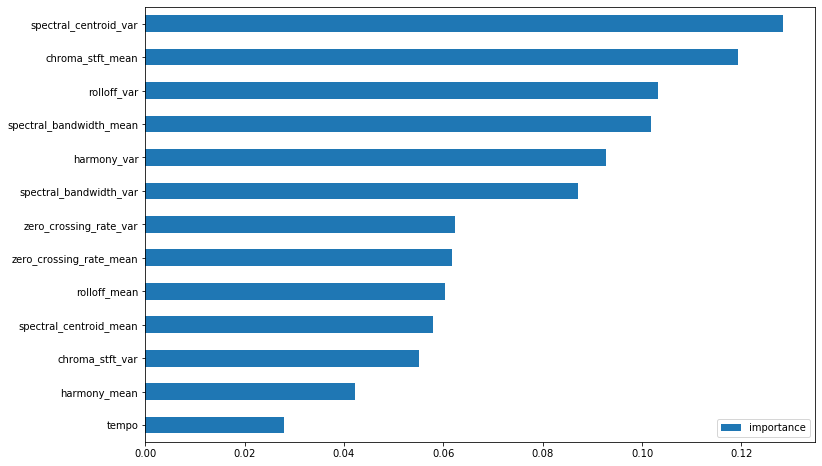

In [43]:
# Классификатор: каггл как трейн

rf=RandomForestClassifier(random_state=0)
parametrs = {'criterion': ['entropy'],'n_estimators': range(10,60,10),'max_depth': range(1,21,1),'min_samples_leaf':range(1,11,1), 'min_samples_split':range(2,11,2)} # параметры взял с потолка, можно будет попроовать поиграться
grid=GridSearchCV(rf, parametrs, cv=3,n_jobs=-1)
grid.fit(X_train, y_train)

grid.best_params_ # потом эти топ параметры можно загнать 

# посмотрим на самые важные фичи
imp_plot = pd.DataFrame(grid.best_estimator_.feature_importances_, index=X_train.columns, columns=['importance'])
imp_plot.sort_values('importance').plot(kind='barh', figsize=(12, 8))

# выберем лучший
grid_best = grid.best_estimator_

In [44]:
#  посмотрим предсказания модели

predictions = grid.predict(X_test) # сработает?

# посмотрим на скор
print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

       blues       0.00      0.00      0.00         0
   classical       0.00      0.00      0.00        17
     country       0.00      0.00      0.00         6
       disco       0.00      0.00      0.00         0
 electronica       0.43      0.96      0.60        72
      hiphop       0.00      0.00      0.00        11
        jazz       0.00      0.00      0.00         3
       metal       0.00      0.00      0.00        19
         pop       0.09      0.08      0.08        13
      reggae       0.00      0.00      0.00         0
        rock       0.00      0.00      0.00        44

    accuracy                           0.38       185
   macro avg       0.05      0.09      0.06       185
weighted avg       0.18      0.38      0.24       185



In [45]:
# попробуем все треки и из них собрать test и train: 

X_full = pd.concat([X_train, X_test])
y_full = pd.concat([y_train, y_test])
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, y_full, test_size=0.2, stratify=y_full, shuffle=True, random_state=42)

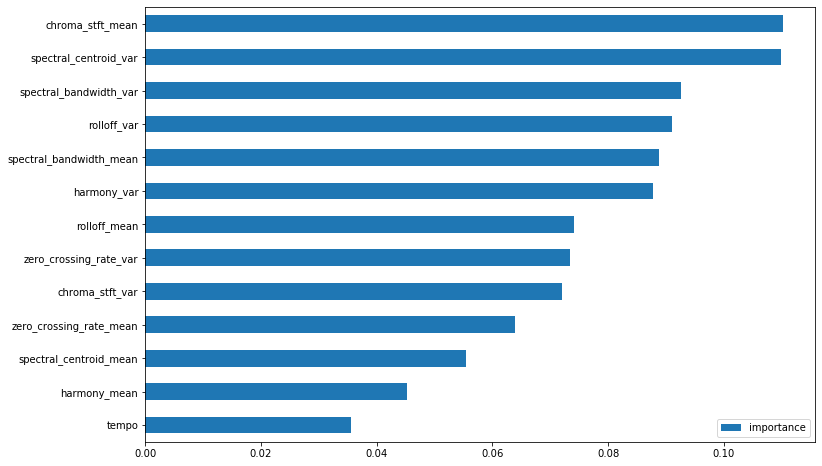

In [46]:
rf_full = RandomForestClassifier(random_state=0)
parametrs = {'criterion': ['entropy'],'n_estimators': range(10,60,10),'max_depth': range(1,21,1),'min_samples_leaf':range(1,11,1), 'min_samples_split':range(2,11,2)} # параметры взял с потолка, можно будет попроовать поиграться
grid_full =GridSearchCV(rf_full, parametrs, cv=3,n_jobs=-1)
grid_full.fit(X_train_full, y_train_full)

grid_full.best_params_ # потом эти топ параметры можно загнать 

# посмотрим на самые важные фичи
imp_plot_full = pd.DataFrame(grid_full.best_estimator_.feature_importances_, index=X_train_full.columns, columns=['importance'])
imp_plot_full.sort_values('importance').plot(kind='barh', figsize=(12, 8))

# выберем лучший
grid_best_full = grid_full.best_estimator_

In [83]:
# выведем параметры grid_search
grid_best_full.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(criterion='entropy', max_depth=11, n_estimators=40,
                       random_state=0)>

In [49]:
predictions_full = grid_full.predict(X_test_full)

print(metrics.classification_report(y_test_full, predictions_full))


              precision    recall  f1-score   support

       blues       0.55      0.60      0.57        20
   classical       0.85      0.74      0.79        23
     country       0.42      0.62      0.50        21
       disco       0.47      0.45      0.46        20
 electronica       0.75      0.88      0.81        34
      hiphop       0.42      0.45      0.43        22
        jazz       0.69      0.52      0.59        21
       metal       0.83      0.83      0.83        24
         pop       0.62      0.43      0.51        23
      reggae       0.58      0.70      0.64        20
        rock       0.43      0.31      0.36        29

    accuracy                           0.60       257
   macro avg       0.60      0.60      0.59       257
weighted avg       0.61      0.60      0.60       257



In [50]:
# RandomForest только на треках IB:

X_train_test, X_test_test, y_train_test, y_test_test = train_test_split(X_test, 
                                                                        y_test, 
                                                                        test_size=0.2, 
                                                                        stratify=y_test, 
                                                                        shuffle=True, 
                                                                        random_state=42)

In [ ]:
rf_test = RandomForestClassifier(random_state=0)
parametrs = {'criterion': ['entropy'],'n_estimators': range(10,60,10),'max_depth': range(1,21,1),'min_samples_leaf':range(1,11,1), 'min_samples_split':range(2,11,2)} # параметры взял с потолка, можно будет попроовать поиграться
grid_test =GridSearchCV(rf_test, parametrs, cv=3,n_jobs=-1)
grid_test.fit(X_train_test, y_train_test)

grid_test.best_params_ # потом эти топ параметры можно загнать 

# посмотрим на самые важные фичи
imp_plot_test = pd.DataFrame(grid_test.best_estimator_.feature_importances_, index=X_train_test.columns, columns=['importance'])
imp_plot_test.sort_values('importance').plot(kind='barh', figsize=(12, 8))

# выберем лучший
grid_best_full = grid_full.best_estimator_

In [105]:
predictions_test = grid_test.predict(X_test_test)  
print(metrics.classification_report(y_test_test, predictions_test))

              precision    recall  f1-score   support

       blues       0.50      0.20      0.29         5
     classic       1.00      0.60      0.75         5
     country       0.17      0.33      0.22         6
       disco       0.75      0.43      0.55         7
 electronica       0.88      0.88      0.88         8
      hiphop       0.86      0.67      0.75         9
        jazz       0.62      0.71      0.67         7
       metal       0.80      0.67      0.73         6
         pop       1.00      0.71      0.83         7
      reggae       0.40      0.33      0.36         6
        rock       0.29      0.57      0.38         7

    accuracy                           0.58        73
   macro avg       0.66      0.55      0.58        73
weighted avg       0.67      0.58      0.60        73



In [51]:
# только обучающая выборка, без примеси треков IB:
X_train_train, X_test_train, y_train_train, y_test_train = train_test_split(X_train, 
                                                                        y_train, 
                                                                        test_size=0.2, 
                                                                        stratify=y_train, 
                                                                        shuffle=True, 
                                                                        random_state=42)

In [52]:
rf_train = RandomForestClassifier(random_state=0)
parametrs = {'criterion': ['entropy'],'n_estimators': range(10,60,10),'max_depth': range(1,21,1),'min_samples_leaf':range(1,11,1), 'min_samples_split':range(2,11,2)} # параметры взял с потолка, можно будет попроовать поиграться
grid_train =GridSearchCV(rf_train, parametrs, cv=3,n_jobs=-1)
grid_train.fit(X_train_train, y_train_train)

grid_test.best_params_ # потом эти топ параметры можно загнать 

# посмотрим на самые важные фичи
imp_plot_train = pd.DataFrame(grid_test.best_estimator_.feature_importances_, index=X_train_train.columns, 
                              columns=['importance'])
imp_plot_train.sort_values('importance').plot(kind='barh', figsize=(12, 8))

# выберем лучший
grid_best_train = grid_train.best_estimator_

NameError: name 'grid_test' is not defined

In [53]:
predictions_train = grid_train.predict(X_test_train)  
print(metrics.classification_report(y_test_train, predictions_train))

              precision    recall  f1-score   support

       blues       0.53      0.45      0.49        20
   classical       0.82      0.90      0.86        20
     country       0.62      0.80      0.70        20
       disco       0.39      0.45      0.42        20
 electronica       0.94      0.80      0.86        20
      hiphop       0.61      0.55      0.58        20
        jazz       0.74      0.70      0.72        20
       metal       0.77      0.85      0.81        20
         pop       0.65      0.75      0.70        20
      reggae       0.39      0.45      0.42        20
        rock       0.20      0.10      0.13        20

    accuracy                           0.62       220
   macro avg       0.61      0.62      0.61       220
weighted avg       0.61      0.62      0.61       220




## KNeighborsClassifier

[[ 0  0  0  0  0  0  0  0  0  0  0]
 [ 2  3  2  0  8  0  0  1  0  0  1]
 [ 0  0  0  1  4  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  3  0 67  1  0  0  0  1  0]
 [ 0  0  0  0 10  0  0  0  1  0  0]
 [ 0  0  0  0  3  0  0  0  0  0  0]
 [ 0  0  1  0  7  2  1  0  3  4  1]
 [ 0  0  0  2  9  0  0  0  0  2  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 36  1  1  0  3  3  0]]
              precision    recall  f1-score   support

       blues       0.00      0.00      0.00         0
   classical       1.00      0.18      0.30        17
     country       0.00      0.00      0.00         6
       disco       0.00      0.00      0.00         0
 electronica       0.47      0.93      0.62        72
      hiphop       0.00      0.00      0.00        11
        jazz       0.00      0.00      0.00         3
       metal       0.00      0.00      0.00        19
         pop       0.00      0.00      0.00        13
      reggae       0.00      0.00      0.00         0
        

Text(0, 0.5, 'Mean Error')

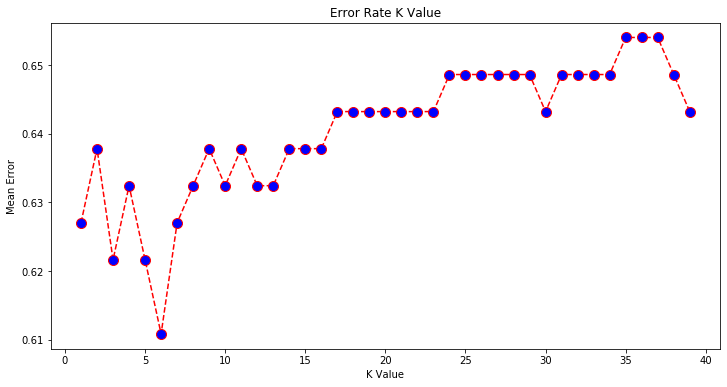

In [54]:
# классификатор

knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train,y_train)
y_knn_predicted = knn.predict(X_test)

# оценка
print(confusion_matrix(y_test, y_knn_predicted))
print(metrics.classification_report(y_test, y_knn_predicted))

# посмотрим за то, правильное ли число соседей выбрали. Потом можно сделать переоценку(re-evaluation)
error = []
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    y_knn_predicted = knn.predict(X_test)
    error.append(np.mean(y_knn_predicted != y_test))

plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

[[ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0 12  1  0  2  0  0  0  0  0  2]
 [ 0  1  1  3  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [10  3  8  8 19  9  2  4  5  3  1]
 [ 3  0  0  1  1  2  0  0  2  1  1]
 [ 1  0  0  0  0  0  1  0  1  0  0]
 [ 2  0  2  3  0  0  1  8  1  0  2]
 [ 3  2  2  2  0  0  2  0  1  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 6  2  7  7  2  4  2  2  4  4  4]]
              precision    recall  f1-score   support

       blues       0.00      0.00      0.00         0
   classical       0.60      0.71      0.65        17
     country       0.05      0.17      0.07         6
       disco       0.00      0.00      0.00         0
 electronica       0.79      0.26      0.40        72
      hiphop       0.13      0.18      0.15        11
        jazz       0.12      0.33      0.18         3
       metal       0.57      0.42      0.48        19
         pop       0.07      0.08      0.07        13
      reggae       0.00      0.00      0.00         0
        

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0, 0.5, 'Mean Error')

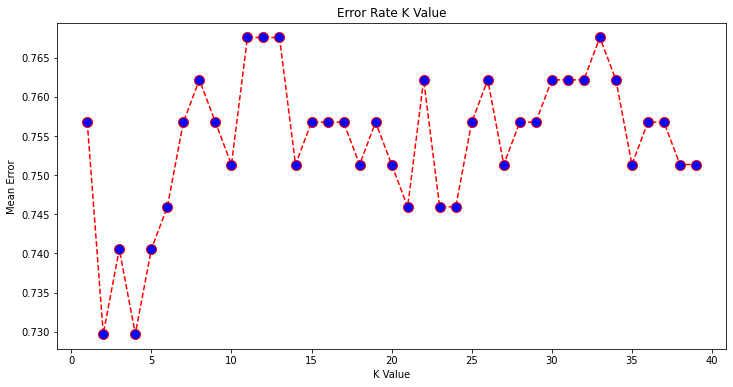

In [62]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train,y_train)
X_test_scaled = scaler.fit_transform(X_test,y_test)
# классификатор

knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train_scaled,y_train)
y_knn_predicted = knn.predict(X_test_scaled)

# оценка
print(confusion_matrix(y_test, y_knn_predicted))
print(metrics.classification_report(y_test, y_knn_predicted))

# посмотрим за то, правильное ли число соседей выбрали. Потом можно сделать переоценку(re-evaluation)
error = []
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_scaled,y_train)
    y_knn_predicted = knn.predict(X_test_scaled)
    error.append(np.mean(y_knn_predicted != y_test))

plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

[[ 5  1  3  3  0  0  2  3  0  3  0]
 [ 2 14  3  0  2  0  1  0  0  1  0]
 [ 3  0  9  2  0  0  0  2  0  3  2]
 [ 1  0  6  5  1  0  0  1  4  1  1]
 [ 0  1  3  0 28  0  0  0  0  2  0]
 [ 2  0  2  4  3  1  0  1  4  5  0]
 [ 5  4  2  1  0  0  3  1  2  2  1]
 [ 3  3  1  0  1  1  0 13  0  1  1]
 [ 0  0  2  3  3  1  0  0  7  6  1]
 [ 0  0  2  2  1  1  0  0  3 11  0]
 [ 2  1  7  8  5  0  0  0  1  3  2]]
              precision    recall  f1-score   support

       blues       0.22      0.25      0.23        20
   classical       0.58      0.61      0.60        23
     country       0.23      0.43      0.30        21
       disco       0.18      0.25      0.21        20
 electronica       0.64      0.82      0.72        34
      hiphop       0.25      0.05      0.08        22
        jazz       0.50      0.14      0.22        21
       metal       0.62      0.54      0.58        24
         pop       0.33      0.30      0.32        23
      reggae       0.29      0.55      0.38        20
        

Text(0, 0.5, 'Mean Error')

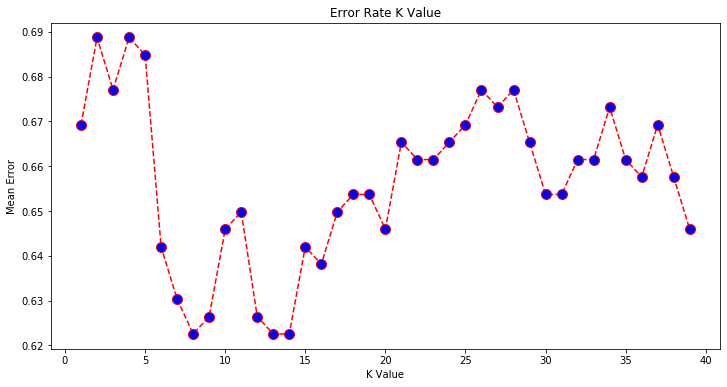

In [55]:
# классификатор

knn_full = KNeighborsClassifier(n_neighbors = 5)
knn_full.fit(X_train_full,y_train_full)
y_knn_predicted_full = knn.predict(X_test_full)

# оценка
print(confusion_matrix(y_test_full, y_knn_predicted_full))
print(metrics.classification_report(y_test_full, y_knn_predicted_full))

# посмотрим за то, правильное ли число соседей выбрали. Потом можно сделать переоценку(re-evaluation)
error = []
for i in range(1, 40):
    knn_full = KNeighborsClassifier(n_neighbors=i)
    knn_full.fit(X_train_full,y_train_full)
    y_knn_predicted_full = knn_full.predict(X_test_full)
    error.append(np.mean(y_knn_predicted_full != y_test_full))

plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

[[ 9  0  7  1  0  0  0  0  1  2  0]
 [ 1 18  0  0  1  0  2  0  0  0  1]
 [ 2  0 13  1  0  0  2  0  2  1  0]
 [ 0  1  0 12  0  2  0  1  3  0  1]
 [ 2  1  2  0 27  1  0  0  0  0  1]
 [ 2  0  2  1  2  6  1  1  2  4  1]
 [ 3  3  4  1  0  2  8  0  0  0  0]
 [ 2  0  1  1  1  0  0 16  0  0  3]
 [ 3  0  0  2  1  2  1  3 11  0  0]
 [ 1  0  1  2  0  3  1  0  3  9  0]
 [ 2  0  7 10  3  1  0  2  2  0  2]]
              precision    recall  f1-score   support

       blues       0.33      0.45      0.38        20
   classical       0.78      0.78      0.78        23
     country       0.35      0.62      0.45        21
       disco       0.39      0.60      0.47        20
 electronica       0.77      0.79      0.78        34
      hiphop       0.35      0.27      0.31        22
        jazz       0.53      0.38      0.44        21
       metal       0.70      0.67      0.68        24
         pop       0.46      0.48      0.47        23
      reggae       0.56      0.45      0.50        20
        

Text(0, 0.5, 'Mean Error')

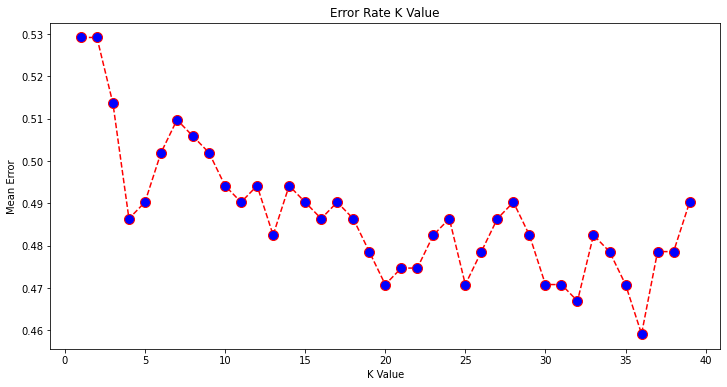

In [66]:
scaler_full = StandardScaler()
X_train_scaled_full = scaler_full.fit_transform(X_train_full,y_train_full)
X_test_scaled_full = scaler_full.fit_transform(X_test_full,y_test_full)
# классификатор

knn_full = KNeighborsClassifier(n_neighbors = 5)
knn_full.fit(X_train_scaled_full,y_train_full)
y_knn_predicted_full = knn_full.predict(X_test_scaled_full)

# оценка
print(confusion_matrix(y_test_full, y_knn_predicted_full))
print(metrics.classification_report(y_test_full, y_knn_predicted_full))

# посмотрим за то, правильное ли число соседей выбрали. Потом можно сделать переоценку(re-evaluation)
error = []
for i in range(1, 40):
    knn_full = KNeighborsClassifier(n_neighbors=i)
    knn_full.fit(X_train_scaled_full,y_train_full)
    y_knn_predicted_full = knn_full.predict(X_test_scaled_full)
    error.append(np.mean(y_knn_predicted_full != y_test_full))

plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

# 6) Multi-label classification

## **1. Предобработка данных, EDA и разбиение на тренировочную и тестовую выборки**

In [ ]:
# считал подсчитанные данные. посмотрел.
#test_data = pd.read_csv('test_data.csv')  # ЗДЕСЬ МОЙ ПУТЬ К ФИЧАМ
#test_data.head()

In [ ]:
# вытащил цифру темпа, привел название файла к нижнему регистру
#test_data['tempo'] = test_data['tempo'].apply(lambda x: float(json.loads(x)[0]))
#test_data['file_title'] = test_data['file_title'].apply(lambda x: x.lower())
#test_data.head()

In [ ]:
# считал аннотацию с жанрами
#annotation = pd.read_csv('fixed_data_final.csv')  # ЗДЕСЬ МОЙ ПУТЬ К АННОТАЦИИ
#annotation.head()

In [ ]:
# привел названия треков к нижнему регистру
#annotation['from_data'] = annotation['from_data'].apply(lambda x: x.lower())

In [ ]:
# смержил аннотацию и фичи
#merged = annotation.merge(test_data, left_on='from_data', right_on='file_title')
#merged
#merged.to_csv('annotated_tracks.csv', sep=',', header=True, index=False)

In [ ]:
#test_merged.head()

file_title  ...        genre3
0                      Tortuga_-_My_Block.mp3  ...           NaN
1                   Свидание-Я_и_твой_кот.mp3  ...           NaN
2  Nightwish-Shudder_Before the Beautiful.mp3  ...  gothic_metal
3        Leave_Home-The_Chemical_Brothers.mp3  ...           NaN
4          Bad_vibes_forever-xxxtentacion.mp3  ...           NaN

[5 rows x 21 columns]

In [56]:
# дропнул ненужные колонки
df = test_merged.drop(['old_name', 'student', 'file_title', 'file_title'], axis=1)
# привел жанры к нижнему регистру
for i in ['genre1', 'genre2', 'genre3']:
    df[i] = df[i].str.lower()

df.head()

duration  chroma_stft_mean  chroma_stft_var  spectral_centroid_mean  \
0  273.473696          0.511729         0.083302             3442.051650   
1  244.117664          0.507524         0.076009             1960.239764   
2  394.155283          0.530715         0.079255             3089.888430   
3  332.199184          0.567891         0.071394             3518.049120   
4  150.492494          0.459269         0.087992             3032.166267   

   spectral_centroid_var  spectral_bandwidth_mean  spectral_bandwidth_var  \
0           2.883000e+06              3700.874664            1.171441e+06   
1           1.828401e+06              2853.390533            1.250619e+06   
2           6.751195e+05              3929.790301            7.171547e+05   
3           2.674195e+06              3679.202446            1.271660e+06   
4           2.786480e+06              3790.248778            9.085854e+05   

   rolloff_mean   rolloff_var  zero_crossing_rate_mean  \
0   7035.072791  1.106361e+07                 0.073445   
1   3999.211575  1.047026e+07                 0.034273   
2   6765.677241  4.845344e+06                 0.051433   
3   7476.593922  1.234161e+07                 0.086108   
4   6547.930958  1.312970e+07                 0.058501   

   zero_crossing_rate_var  harmony_mean  harmony_var       tempo coarse_genre  \
0                0.005399      0.000190     0.118548  126.048018  electronica   
1                0.001669     -0.000015     0.038252  101.332721          pop   
2                0.000496     -0.000005     0.044011  126.048018        metal   
3                0.003908     -0.001493     0.051288  143.554688  electronica   
4                0.004182      0.000012     0.041802  129.199219       hiphop   

        genre1      genre2        genre3  
0        blues         NaN           NaN  
1         rock         NaN           NaN  
2  power_metal  folk_metal  gothic_metal  
3     trip-hop         NaN           NaN  
4          rap         NaN           NaN

In [57]:
# посмотрел на поджанры
print('Genre 1: ', df['genre1'].unique())
print('Genre 2: ', df['genre2'].unique())
print('Genre 3: ', df['genre3'].unique())

Genre 1:  ['blues' 'rock' 'power_metal' 'trip-hop' 'rap' nan 'drum_and_bass'
 'alternative_rock' 'synthwave' 'pop rock' 'alternative_hip-hop'
 'downtempo' 'ambient_techno' 'dubstep' 'house' 'alt_rock' 'techno'
 'chilwave' 'traditional_pop' 'speed_metal' 'blues rock' 'electronic-rock'
 'neo-classic' 'russian rock' 'soundtrack' 'breakbeat' 'french pop' 'bit'
 'pop-rock' 'indastrial' 'classic russian pop' 'pop' 'psychodelic rock'
 'industrial' 'hip-hop' 'folk-rock' 'folk' 'modern jazz' 'drill and bass'
 'french jazz' 'country' 'j-rock' 'trap' 'indie' "r'n'b"
 'russian electronic' 'instrumental' 'russian indian' 'disco'
 'classical russian rock' 'russian hip-hop' 'indie rock' 'indie-rock'
 'britpop' 'electronic' 'acoustic rock' 'indie_folk' 'aria'
 'neo-classical' 'garage_rock' 'swing' 'balcan music' 'shoegaze' 'idm'
 'psychodelic' 'alternative' 'folk_rock']
Genre 2:  [nan 'folk_metal' 'symphonic_metal' 'indie rock' 'downtempo' 'ambient'
 'folk' 'rock' 'glam rock' 'electronic' 'big_band' '

In [58]:
# исправил косяки в нейминге и объединил некоторые жанры
df = df.replace(' |-', '_', regex=True)
df = df.replace({'genre1': { 'alternative_rock': 'alternative', 'alt_rock' : 'alternative', 
                             'neo_classical' : 'neo_classic', 'psychodelic_' : 'psychedelic',
                             'chilwave': 'chillwave', 'classical_russian_rock': 'russian_rock',
                             'indastrial': 'industrial'
                            },
                 'genre2': {'russian_hyp_hop': 'russian_hip_hop', '_ambient': 'ambient'},
                 'genre3': {'russian_hyp_hop': 'russian_hip_hop'}
    })
# russian_hyp_hop, chilwave и indastrial просто пушка, конечно
# посмотрел, что получилось в итоге
print('Genre 1: ', df['genre1'].unique(), '\n')
print('Genre 2: ', df['genre2'].unique(), '\n')
print('Genre 3: ', df['genre3'].unique())

Genre 1:  ['blues' 'rock' 'power_metal' 'trip_hop' 'rap' nan 'drum_and_bass'
 'alternative' 'synthwave' 'pop_rock' 'alternative_hip_hop' 'downtempo'
 'ambient_techno' 'dubstep' 'house' 'techno' 'chillwave' 'traditional_pop'
 'speed_metal' 'blues_rock' 'electronic_rock' 'neo_classic' 'russian_rock'
 'soundtrack' 'breakbeat' 'french_pop' 'bit' 'industrial'
 'classic_russian_pop' 'pop' 'psychodelic_rock' 'hip_hop' 'folk_rock'
 'folk' 'modern_jazz' 'drill_and_bass' 'french_jazz' 'country' 'j_rock'
 'trap' 'indie' "r'n'b" 'russian_electronic' 'instrumental'
 'russian_indian' 'disco' 'russian_hip_hop' 'indie_rock' 'britpop'
 'electronic' 'acoustic_rock' 'indie_folk' 'aria' 'garage_rock' 'swing'
 'balcan_music' 'shoegaze' 'idm' 'psychodelic'] 

Genre 2:  [nan 'folk_metal' 'symphonic_metal' 'indie_rock' 'downtempo' 'ambient'
 'folk' 'rock' 'glam_rock' 'electronic' 'big_band' 'hard_rock' 'bard_song'
 'alternative_rock' 'russian_electronic' 'neo_classic' 'chanson'
 'funk_rock' 'drill' 'trip_hop'

In [60]:
# итоговый датафрейм
df.head()

duration  chroma_stft_mean  chroma_stft_var  spectral_centroid_mean  \
0  273.473696          0.511729         0.083302             3442.051650   
1  244.117664          0.507524         0.076009             1960.239764   
2  394.155283          0.530715         0.079255             3089.888430   
3  332.199184          0.567891         0.071394             3518.049120   
4  150.492494          0.459269         0.087992             3032.166267   

   spectral_centroid_var  spectral_bandwidth_mean  spectral_bandwidth_var  \
0           2.883000e+06              3700.874664            1.171441e+06   
1           1.828401e+06              2853.390533            1.250619e+06   
2           6.751195e+05              3929.790301            7.171547e+05   
3           2.674195e+06              3679.202446            1.271660e+06   
4           2.786480e+06              3790.248778            9.085854e+05   

   rolloff_mean   rolloff_var  zero_crossing_rate_mean  \
0   7035.072791  1.106361e+07                 0.073445   
1   3999.211575  1.047026e+07                 0.034273   
2   6765.677241  4.845344e+06                 0.051433   
3   7476.593922  1.234161e+07                 0.086108   
4   6547.930958  1.312970e+07                 0.058501   

   zero_crossing_rate_var  harmony_mean  harmony_var       tempo coarse_genre  \
0                0.005399      0.000190     0.118548  126.048018  electronica   
1                0.001669     -0.000015     0.038252  101.332721          pop   
2                0.000496     -0.000005     0.044011  126.048018        metal   
3                0.003908     -0.001493     0.051288  143.554688  electronica   
4                0.004182      0.000012     0.041802  129.199219       hiphop   

        genre1      genre2        genre3  
0        blues         NaN           NaN  
1         rock         NaN           NaN  
2  power_metal  folk_metal  gothic_metal  
3     trip_hop         NaN           NaN  
4          rap         NaN           NaN

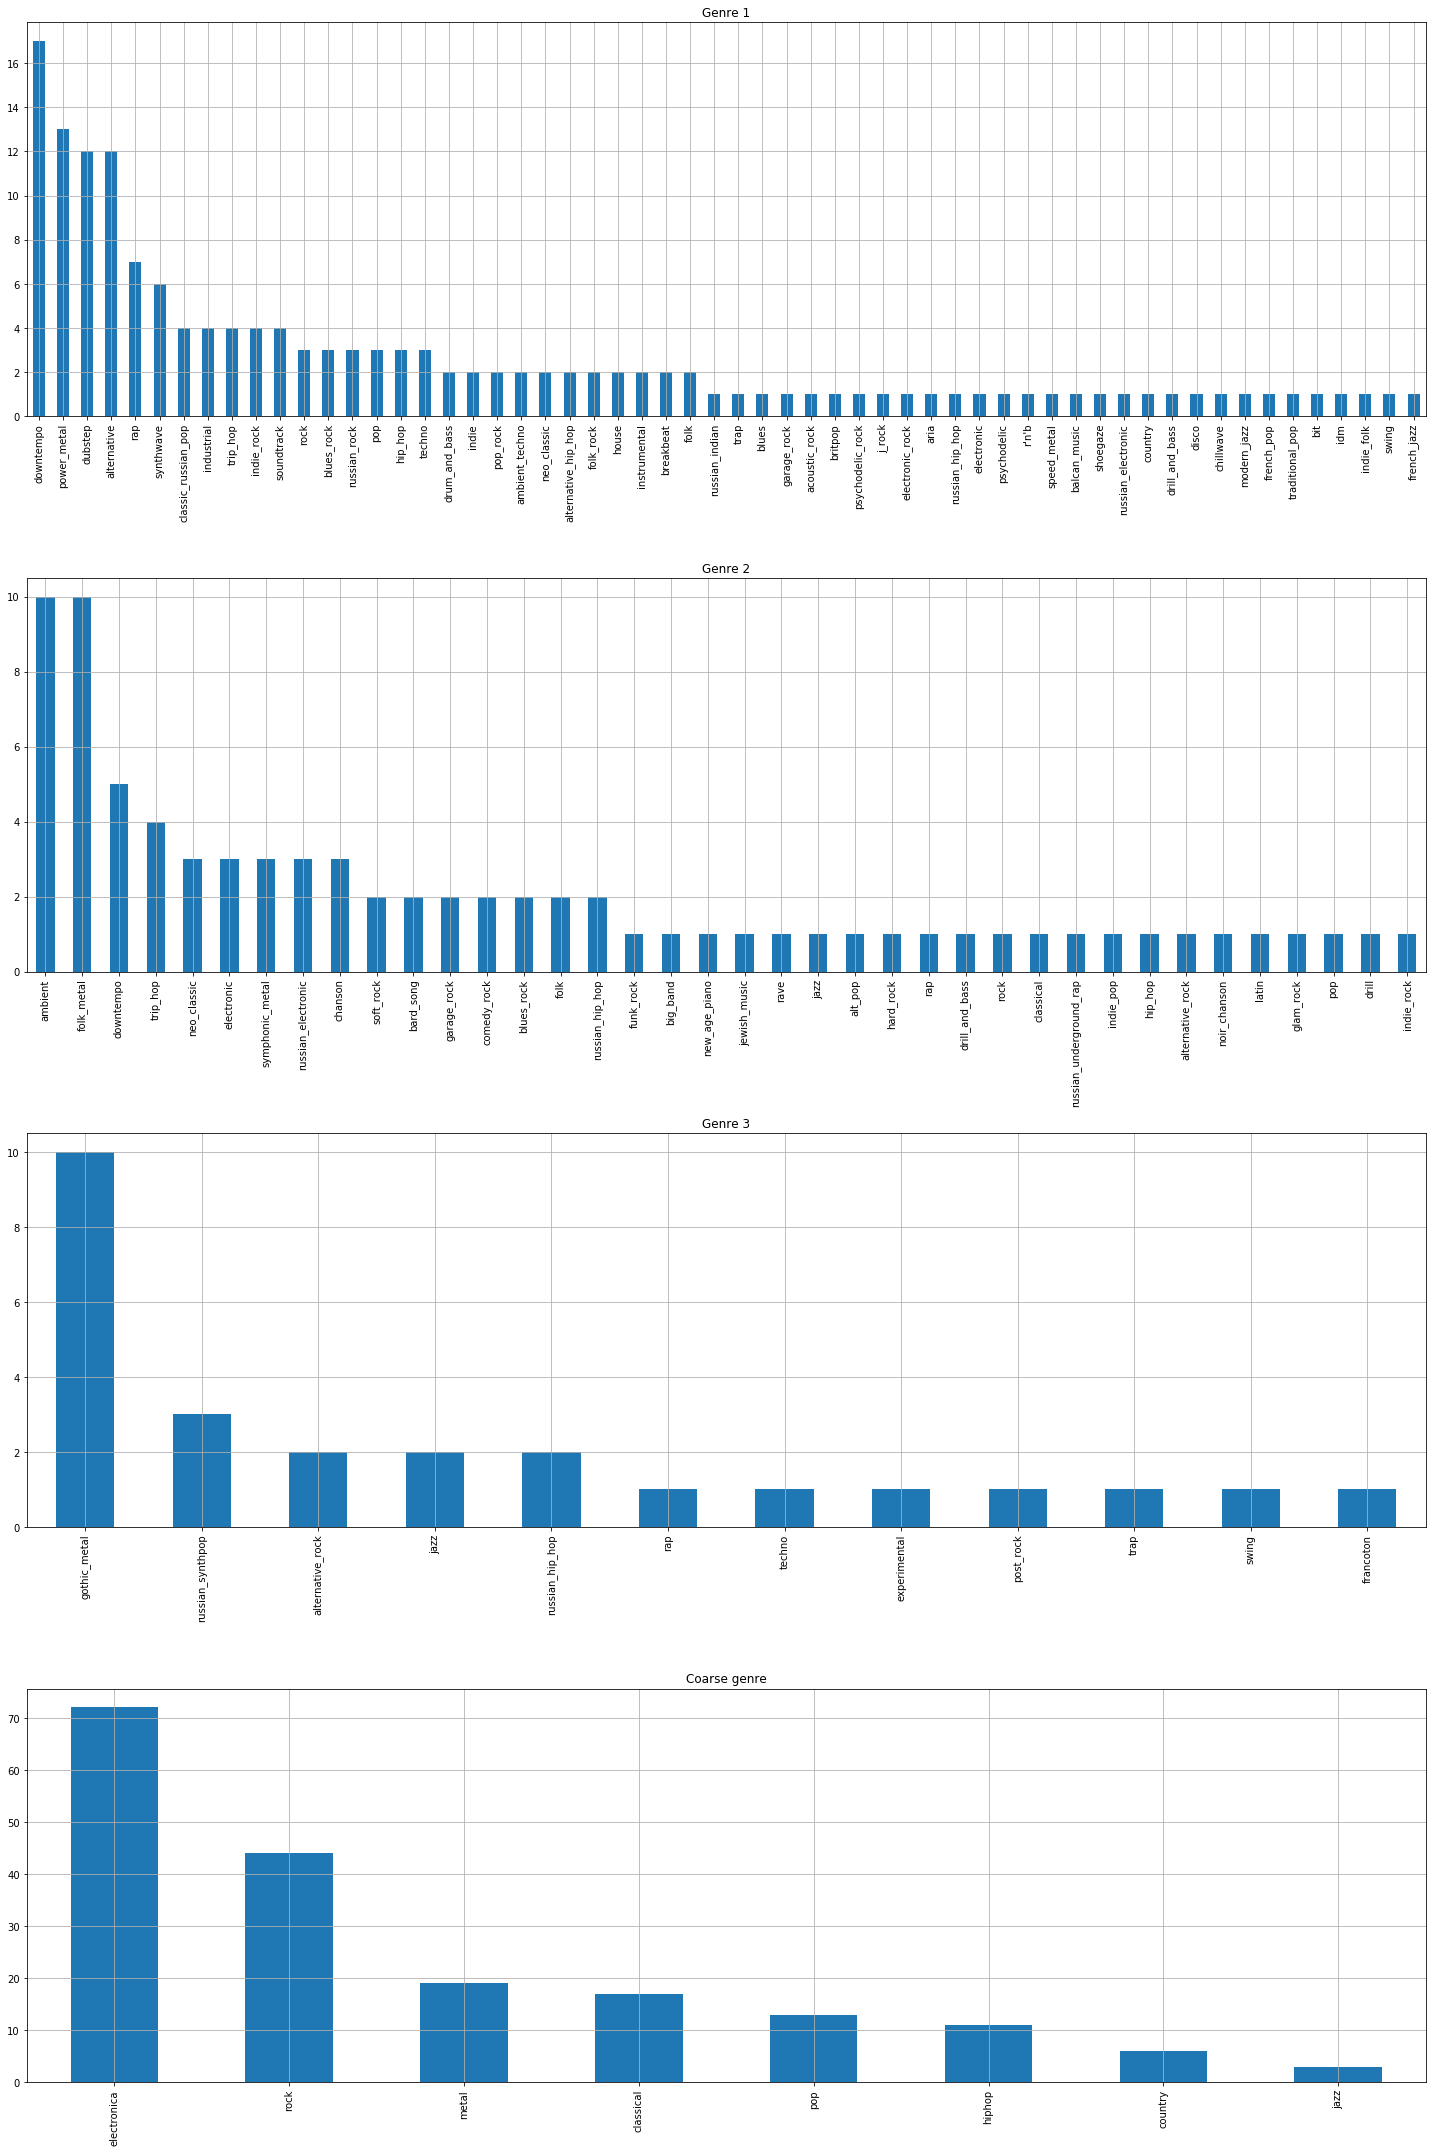

In [59]:
# барплоты распределения треков по жанрам и поджанрам в каждой колонке
fig, axs = plt.subplots(nrows=4, figsize=(20, 30))
df.genre1.value_counts().plot(ax=axs[0], kind='bar', grid=True, title='Genre 1')
df.genre2.value_counts().plot(ax=axs[1], kind='bar', grid=True, title='Genre 2')
df.genre3.value_counts().plot(ax=axs[2], kind='bar', grid=True, title='Genre 3')
df.coarse_genre.value_counts().plot(ax=axs[3], kind='bar', grid=True, title='Coarse genre')
#plt.suptitle('Распределение треков по жанрам и поджанрам')
plt.tight_layout()

In [61]:
# конверсия в dummy variables
coarse_genre = pd.get_dummies(df['coarse_genre'])
genre1 = pd.get_dummies(df['genre1'])
genre2 = pd.get_dummies(df['genre2'])
genre3 = pd.get_dummies(df['genre3'])
# соединяем в один датафрейм и схлопываем колонки с одинаковыми названиями
y = pd.concat([coarse_genre, genre1, genre2, genre3], axis=1).groupby(level=0, axis=1).any().astype(int)  # у, потому что здесь только жанры - то, что нужно

Text(0.5, 1, 'Поджанры треков')

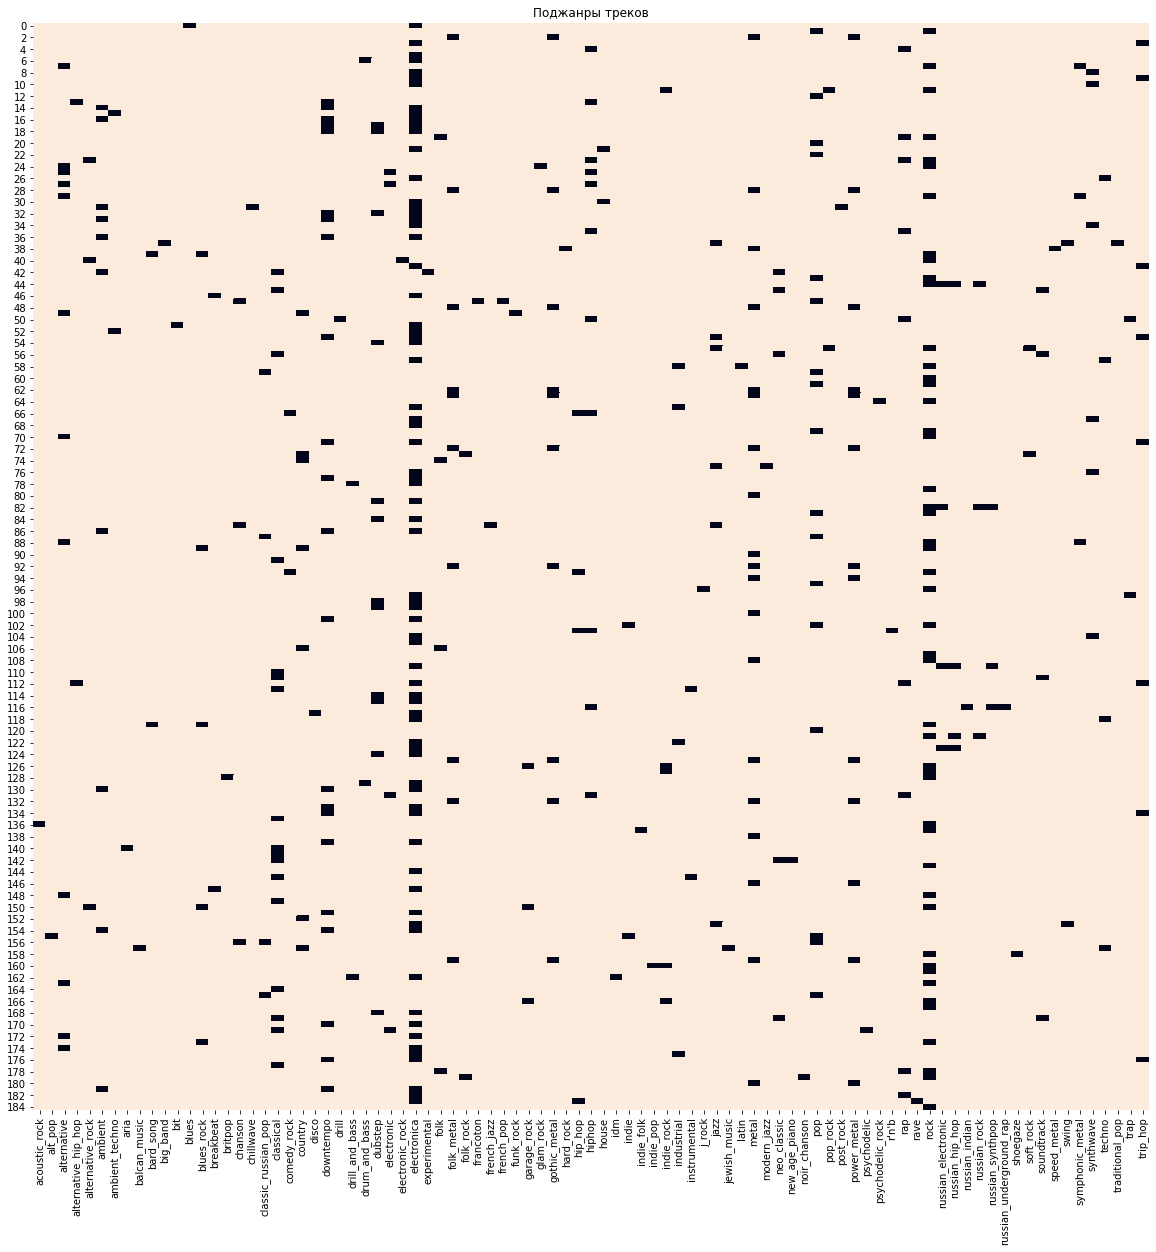

In [62]:
# хитмэп распределения треков по всем поджанрам
fig, ax = plt.subplots(figsize = (20, 20))
sns.heatmap(y, cmap=sns.cm.rocket_r, cbar=False)
plt.title('Поджанры треков')

In [63]:
# сформировал X - убрал колонки с жанрами
X = df.drop(['coarse_genre', 'genre1', 'genre2', 'genre3'], axis=1)

In [64]:
# разбиение на трейн и тест сеты
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## **2. Оценка эффективности разных подходов к multi-label классификации**

Есть несколько разных подходов к multi-label классификации, а именно: 

1. Binary Relevance
2. Classifier Chain
3. Label Powerset
4. Multi-Label K Nearest Neighbors (MLkNN)

В рамках каждого подхода, кроме последнего, можно использовать разные классификаторы. Поэтому для первых трех подходов я использовал два варианта классификаторов: Gaussian Naive Bayes и Random Forest. Сравнивал их на основе accuracy (первичная оценка), а также строил multi-label confusion matrix для каждого подхода и оценивал Micro-averaged Precision, Recall и F1-Score. 

### **2.1. Binary Relevance**

In [68]:

# initialize binary relevance multi-label classifier
# with a gaussian naive bayes base classifier
classifier = BinaryRelevance(GaussianNB())

# train
classifier.fit(X_train, y_train)

# predict
predictions = classifier.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, predictions)}')
print(classification_report(y_test, predictions))
# print(multilabel_confusion_matrix(y_test, predictions))
# все очень плохо

Accuracy: 0.0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         0
           4       0.20      1.00      0.33         1
           5       0.06      0.33      0.10         3
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         3
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         2
          17 

In [66]:
# попробовал засунуть внутрь RF

# initialize binary relevance multi-label classifier
# with a Random Forest classifier
classifier = BinaryRelevance(RandomForestClassifier())

# train
classifier.fit(X_train, y_train)

# predict
predictions = classifier.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, predictions)}')
print(classification_report(y_test, predictions))
# print(multilabel_confusion_matrix(y_test, predictions))
# все очень плохо

Accuracy: 0.06451612903225806
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         1
           5       0.50      0.33      0.40         3
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         3
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00        

### **2.2. Classifier Chains**

In [69]:
from skmultilearn.problem_transform import ClassifierChain

# initialize classifier chains multi-label classifier
# with a gaussian naive bayes base classifier
classifier = ClassifierChain(GaussianNB())

# train
classifier.fit(X_train, y_train)

# predict
predictions = classifier.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, predictions)}')
print(classification_report(y_test, predictions))
# print(multilabel_confusion_matrix(y_test, predictions))
# все очень плохо

Accuracy: 0.0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         0
           4       0.20      1.00      0.33         1
           5       0.06      0.33      0.10         3
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         3
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         2
          17 

In [70]:
# попробуем засунуть RF
# initialize classifier chains multi-label classifier
# with a Random Forest classifier
classifier = ClassifierChain(RandomForestClassifier())

# train
classifier.fit(X_train, y_train)

# predict
predictions = classifier.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, predictions)}')
print(classification_report(y_test, predictions))
# print(multilabel_confusion_matrix(y_test, predictions))
# все очень плохо

Accuracy: 0.08064516129032258
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         1
           5       0.50      0.33      0.40         3
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         3
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00        

### **2.3. Label Powerset**

In [71]:

# initialize Label Powerset multi-label classifier
# with a gaussian naive bayes base classifier
classifier = LabelPowerset(GaussianNB())

# train
classifier.fit(X_train, y_train)

# predict
predictions = classifier.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, predictions)}')
print(classification_report(y_test, predictions))
# print(multilabel_confusion_matrix(y_test, predictions))
# все очень плохо

Accuracy: 0.08064516129032258
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         1
           5       0.12      0.33      0.18         3
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         3
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00        

In [72]:
# попробуем засунуть RF
# initialize Label Powerset multi-label classifier
# with a gaussian naive bayes base classifier
classifier = LabelPowerset(RandomForestClassifier())

# train
classifier.fit(X_train, y_train)

# predict
predictions = classifier.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, predictions)}')
print(classification_report(y_test, predictions))
# print(multilabel_confusion_matrix(y_test, predictions))
# все плохо, но не настолько, как раньше. пока что это лучший результат

Accuracy: 0.12903225806451613
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         1
           5       0.08      0.33      0.13         3
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         3
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00        

### **2.4. MLkNN**

In [74]:


# finding optimal parameters with GridSearchCV
parameters = {'k': range(3, 50), 's': [0.5, 0.7, 1.0]}
score = 'f1_macro'

classifier = GridSearchCV(MLkNN(), parameters, scoring=score, n_jobs=-1)
# train
classifier.fit(np.array(X_train), np.array(y_train))

print(classifier.best_params_, classifier.best_score_)
# все очень плохо

# predict
predictions = classifier.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, predictions)}')
print(classification_report(y_test, predictions))
# print(multilabel_confusion_matrix(y_test, predictions))

{'k': 3, 's': 0.5} 0.020935891603439522
Accuracy: 0.016129032258064516
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         3
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         3
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         0
          

**Итог**

Лучше всего себя показал алгоритм Label Powerset с Random Forest внутри. визуализировал для него confusion matrix (она выглядит как набор confusion matrices для каждого класса, поэтому не стал визуализировать или выводить ее на печать для других алгоритмов).

## **3. Визуализация и тестирование наилучшего алгоритма**


In [75]:
# на основе раздела 2 выберем наилучший классификатор, натренируем его и снова предскажем значения
best_classifier = LabelPowerset(RandomForestClassifier())

# train
best_classifier.fit(X_train, y_train)

# predict
predictions = best_classifier.predict(X_test)


In [76]:
# проверил, сколько жанров всего - потом пригодится
len(y_train.columns)

89

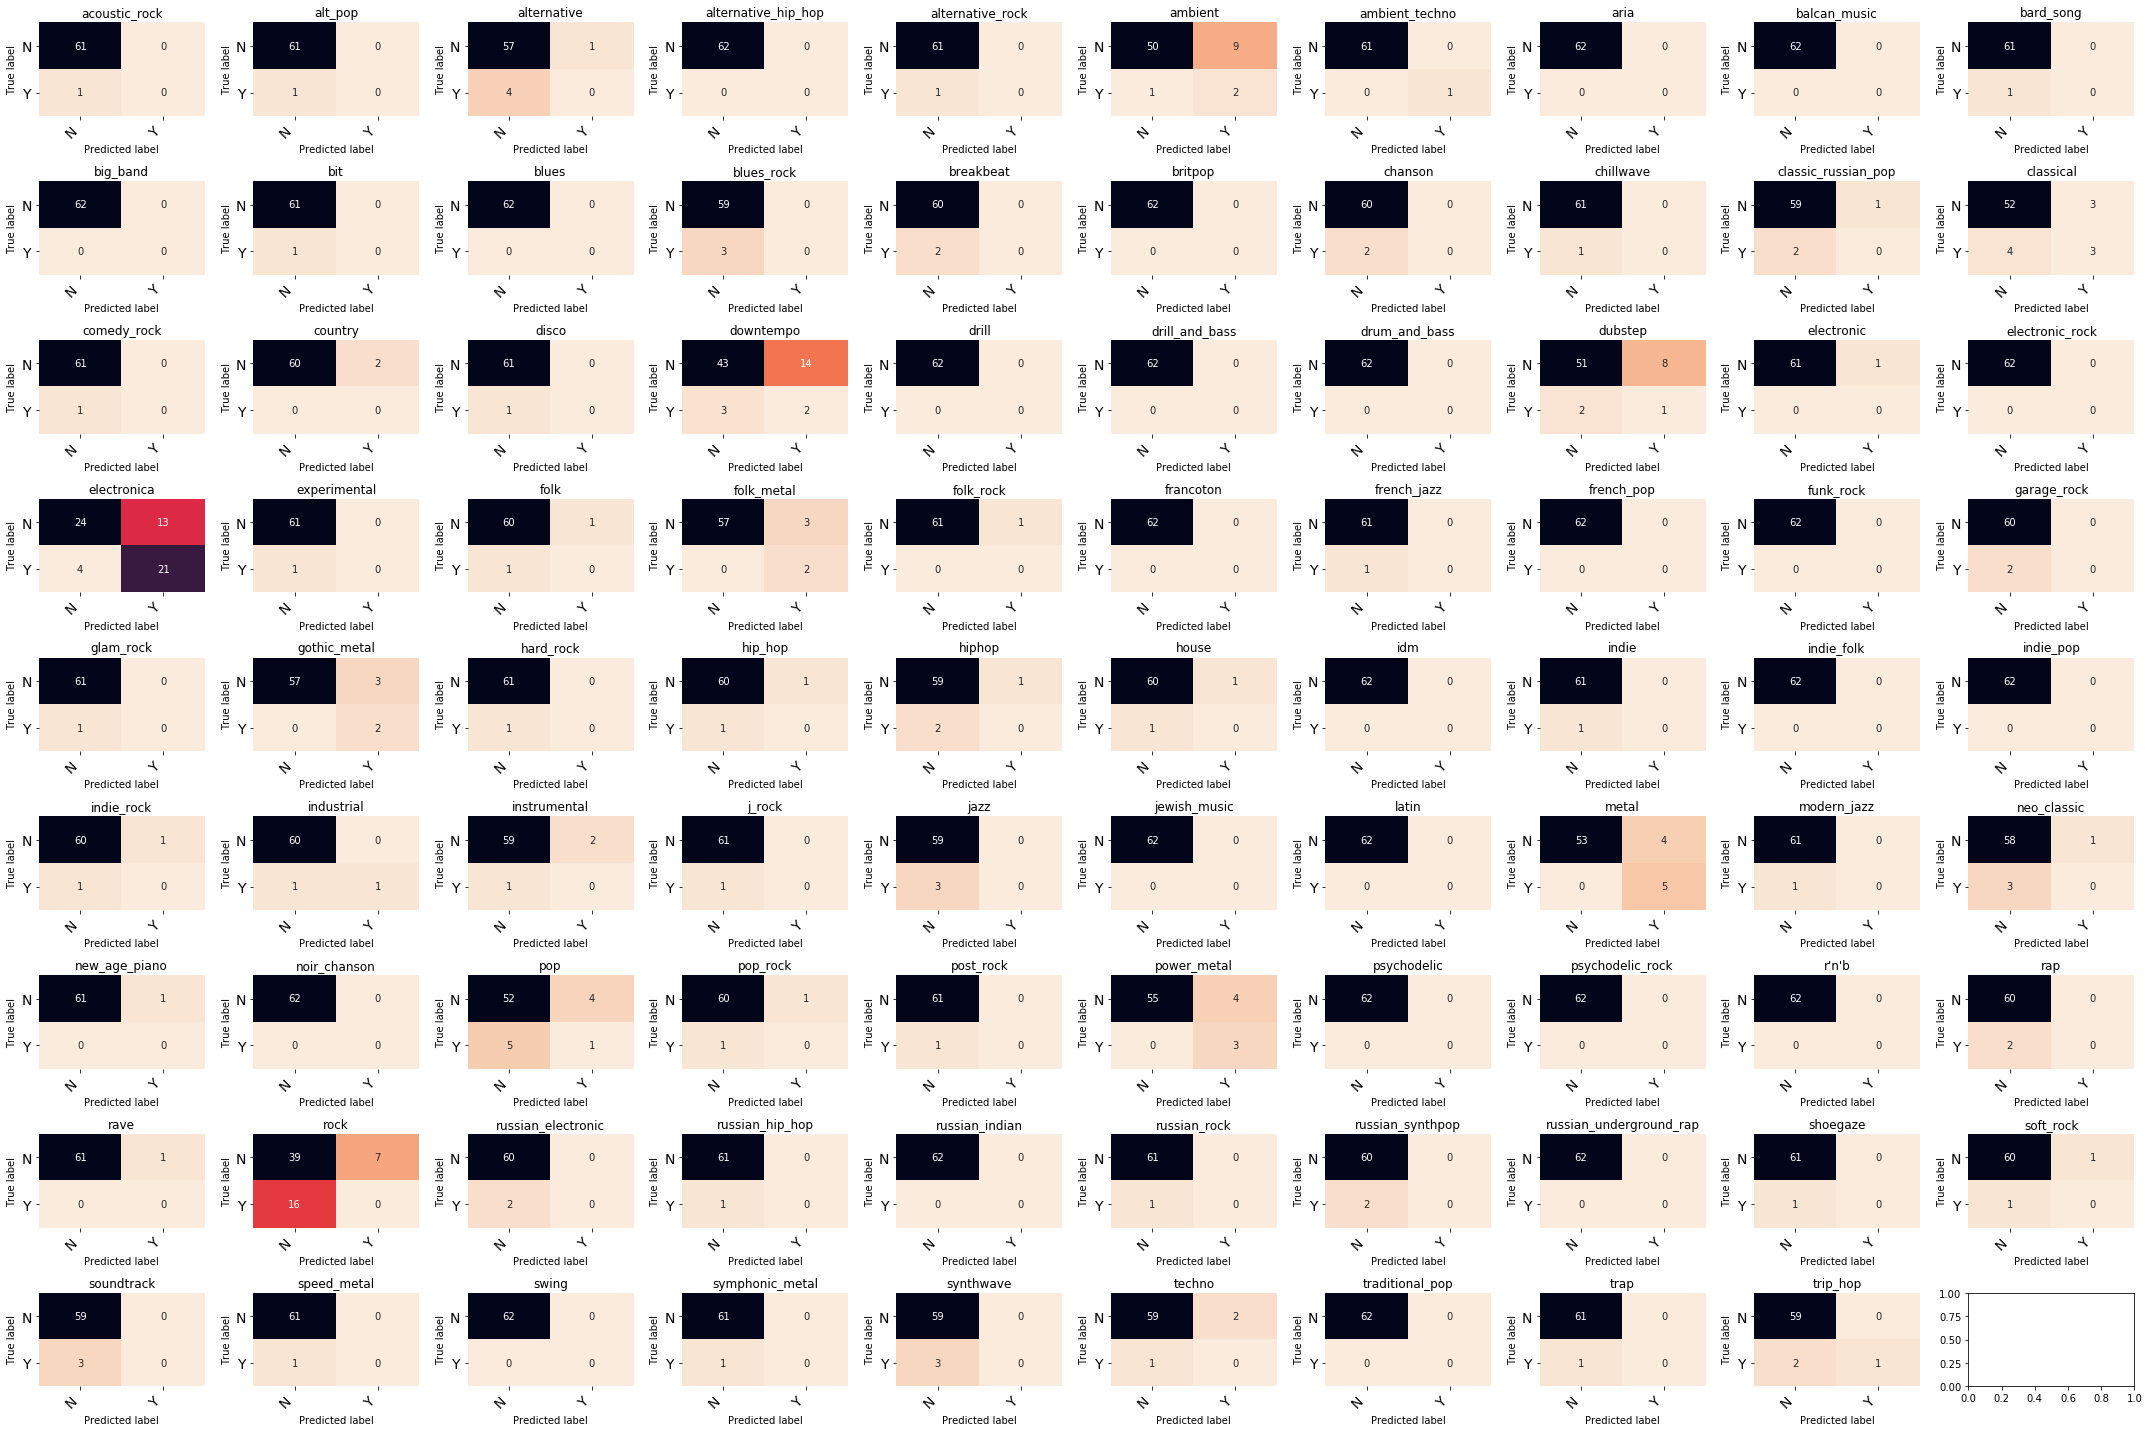

In [77]:
# визуализация multi-label confusion matrix

vis_arr = multilabel_confusion_matrix(y_test, predictions)
labels = y_train.columns
#["".join("c" + str(i)) for i in range(0, 16)]


def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes, cmap = sns.cm.rocket_r)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title(class_label)
    
fig, ax = plt.subplots(9, 10, figsize=(30, 20))  # количество жанров из предыдущего чанка пригодилось здесь - организовал графики в сетку 9x10
    
for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    
fig.tight_layout()
plt.show()

In [ ]:
# TODO: выбрать и построить лучшие confusion matrices. Добавить ROC/PRC???

## **4. Реализация исходного ТЗ от Саши Ильина: при подаче трека на вход выдать список возможных поджанров**

In [79]:
path = './track/'  # ЗДЕСЬ МОЙ ПУТЬ К ФАЙЛАМ
files = os.listdir(path)  
# в папке может лежать либо один трек, для которого мы хотим определить поджанры, либо альбом
# в случае альбома поджанры определятся для каждого трека, на выходе получим множество уникальных поджанров

In [80]:
# кусок от Паши и Кристины - работает довольно долго, но я не стал ломать голову и писать свой

column_names = ['file_title', 'duration', 'chroma_stft_mean', 'chroma_stft_var', 'spec_cent_mean', 'spec_cent_var', 
                'spec_bw_mean', 'spec_bw_var', 'rolloff_mean', 'rolloff_var', 'zcr_mean', 'zcr_var', 
                'harmony_mean', 'harmony_var', 'tempo']
my_tracks = pd.DataFrame(columns = column_names)
files = ['aux-88_alien-life-form.mp3']
for file in files:
    title = file
    path_to_file = path + file
    
    # rough feature extraction
    y, sr = librosa.load(path_to_file, sr=44100)
    duration = librosa.get_duration(y=y, sr=sr)
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y=y)
    harmony = librosa.effects.harmonic(y=y)
    tempo = librosa.beat.tempo(y=y, sr=sr)
    
    # наращивание датафрейма
    df_temp = pd.DataFrame([[file, 
                             duration,
                             chroma_stft.mean(),
                             chroma_stft.var(),
                             spec_cent.mean(),
                             spec_cent.var(),
                             spec_bw.mean(),
                             spec_bw.var(),
                             rolloff.mean(),
                             rolloff.var(),
                             zcr.mean(),
                             zcr.var(),
                             harmony.mean(),
                             harmony.var(),
                             tempo
                            ]], 
                           columns=column_names)
    my_tracks = my_tracks.append(df_temp)

In [81]:
# вытащить темп (почему-то json в этот раз работать не захотел), дропнуть название
my_tracks['tempo'] = my_tracks['tempo'].apply(lambda x: float((x)[0]))
my_tracks_test = my_tracks.drop(['file_title'], axis=1)

In [82]:
# predict
output = best_classifier.predict(my_tracks_test)

# достать жанры
genres = y_test.columns[[i for i in output.nonzero()[1]]].unique()  

# вывести на печать
print('Genre: ', ', '.join(genres))

Genre:  downtempo, dubstep, electronica


## **5. Выводы**
1. Accuracy невысокая, но лучше добиться на таких данных без применения нейросеток сложно.
2. Хорошо представленные жанры определяются лучше всего, что логично.
3. **Garbage in - garbage out (c)**